#### Corporation Favorita Time Series Regression Analysis

### **Problem Statement**

Corporation Favorita, a prominent a large Ecuadorian-based grocery retailer, aims to ensure that they always have the right quantity of products in stock. To acheive this as a data scientist in Corporation Favorita, we will build a series of machine learning models to forecast the demand of products in various locations.

### **Objective**
The primary objective of this project is to develop a robust time series regression model that more accurately predicts the unit sales for thousands of items. Importantfor Corporation Favorita’s various products across its different store locations. The model should account for historical sales data, promotional activities, holidays, and other relevant factors that influence sales.

### **Expected Impact**
By developing an accurate sales forecasting model, Corporation Favorita can better manage its inventory, reduce stockouts and overstock situations, and enhance overall customer satisfaction. This project will contribute to the company’s strategic planning and operational efficiency, ultimately driving higher profitability and growth.

### Features

**Null Hypothesis (H₀):** There is no changes in sales a

**Alternative Hypothesis (H₁):** There is a significant relationship between historical sales data, promotional activities, holidays, and other external factors, and the future sales of Corporation Favorita's products.

### **Analitical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?


In [2]:
#importing the needed libraries
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, boxcox, shapiro, mannwhitneyu

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder



In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
login = environment_variables.get("LOGIN")
password = environment_variables.get("PASSWORD")


In [5]:
# Create connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={login};"
    f"PWD={password};"
)

# Establish the connection
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except pyodbc.InterfaceError as e:
    print(f"InterfaceError: {e}")
except pyodbc.Error as e:
    print(f"Database connection error: {e}")

Connection successful


In [6]:
# Write SQL Query to get data from the database.
query="Select * from dbo.oil"
oil = pd.read_sql(query,connection)

# Display the first 5 rows of the data

oil.head(5)

C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\2938101969.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  oil = pd.read_sql(query,connection)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
query="Select * from dbo.holidays_events"
holidays_events = pd.read_sql(query,connection)

# Display the first 5 rows of the data

holidays_events.head(5)

C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\3914639830.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  holidays_events = pd.read_sql(query,connection)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

'Transfer' are the holidays that occured on a particular date but were observed on a different date. These holidays officially fall on the specified calendar date but were moved to another date by the government. This could be because the holidays occured in a weekend, or for any other reason. Since we are interested in the store sales performance on the actual days that holidays were observed, the holidays with type as 'Trasfer' will be isolated, and their holiday date changed to the actual date each holiday was observed.

In [9]:
# Filter holidays with 'type' as 'Transfer'
transferred_holidays = holidays_events[holidays_events['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
transferred_holidays

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [10]:
# Function to change the date of transferred holidays to the date the holidays were observed
def change_transferred_holidays_date(row):
    if row['type'] == 'Transfer':
        corresponding_row = holidays_events[(holidays_events['description'] == row['description']) & 
                                               (holidays_events['type'] != 'Transfer') & 
                                               (holidays_events['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to change the date of transferred holidays to the date the holidays were observed
holidays_events['date'] = holidays_events.apply(change_transferred_holidays_date, axis=1)

# Drop any duplicate rows created
holidays_events.drop_duplicates(inplace=True)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
query="Select * from dbo.stores"
stores = pd.read_sql(query,connection)

# Display the first 5 rows of the data

stores.head(5)

C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\3537192254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stores = pd.read_sql(query,connection)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [13]:
# Change the datatypes of the columns (except 'store_nbr') in stores dataset to category for consistency and ease in handling the dataset
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['type'] = stores['type'].astype('category')
stores['cluster'] = stores['cluster'].astype('category')

# Verify the changes
stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

In [14]:
train = pd.read_csv(r"C:\Users\Kwame Yeboah\OneDrive\Desktop\Career Accelerator\LP-3 Favorita Time Series\Stores-Sales-prediction\Data\train.csv")

# Display the first 5 rows of the data
train.head(5) 


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [15]:
transactions = pd.read_csv(r"C:\Users\Kwame Yeboah\OneDrive\Desktop\Career Accelerator\LP-3 Favorita Time Series\Stores-Sales-prediction\Data\transactions.csv")

# Display the first 5 rows of the data

transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [16]:
# Create a dictionary of the datasets
data = {'holiday': holidays_events, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train}



In [17]:
# Check the datatypes and presence of missing values in each of the datasets
# Using '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')


For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), int64(1)
memory usa

In [18]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')


For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________




### **Probles with the datasets** 
 - Looking at the overview of the whole datasets the only column with missing values is "dcoilwtico" (price column), which has 43 missing valus 
 - All the date columns in the dataset are all in obect format
 - There are no duplicates in the dataset.
 - There is no column to identify the days in which there were holidays and days in which there were no holidays.

#### **Merging the dataset**

In [19]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

In [20]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holidays_events, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

df = df4.copy()

#### **Exploratory Analysis**

Since the datasets has been joined, we can go ahead and explore it further.

In [21]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'type_x', 'locale', 'locale_name', 'description',
       'transferred', 'dcoilwtico', 'city', 'state', 'type_y', 'cluster'],
      dtype='object')

In [22]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df = df.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y': 'store_type'})
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [23]:
df.duplicated().sum()

np.int64(0)

In [24]:
df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

The missing values in the transactions column will be filled with 0 because it represents the absence of transactions on those days.

In [25]:
# Fill the missing values in the transactions column with 0

df['transactions'].fillna(0, inplace=True)
df.isna().sum()

C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\2224558830.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['transactions'].fillna(0, inplace=True)


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

For holiday_type, locale, locale_name, description and transferred columns, there are equal number of missing values. This is because these columns are from the holiday dataset, and they represent the days where there were no holidays. These empty cells will be filled with 'No holiday' for easy identification.

In [26]:
# Fill the missing values in type_x, locale, locale_name, description and transferred columns with 'No holiday'
columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df[column].fillna('No holiday', inplace=True)

# Confirm that there are no more missing values in these columns
df.isna().sum()

C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\3408715499.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna('No holiday', inplace=True)


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

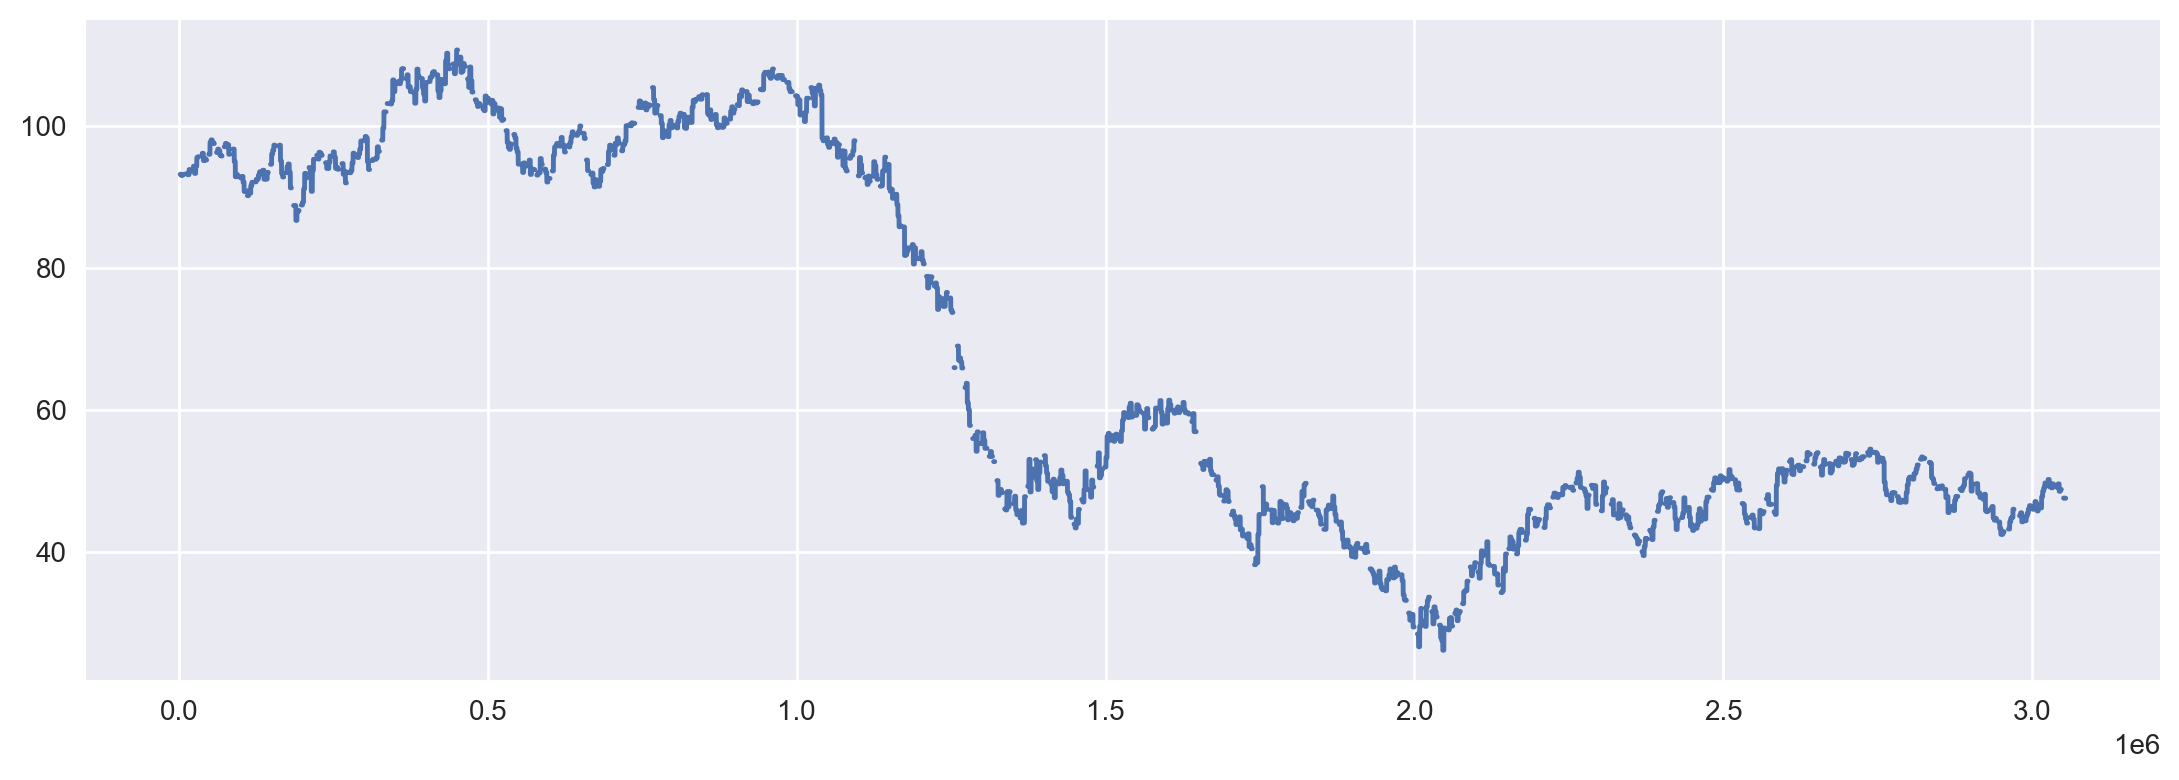

In [27]:
# Visualize the trend of oil prices before filling the missing values in the 'oil_price' column

df['oil_price'].plot()

The plot shows breakages indicating missing data points. Backward fill (bfill) can fill missing values by replacing them with the next known value in the time series. This approach is useful if you assume that the subsequent data points represent the missing values accurately.

In [28]:
df['oil_price'].fillna(method='bfill', inplace=True)


C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\2792375325.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['oil_price'].fillna(method='bfill', inplace=True)


<Axes: >

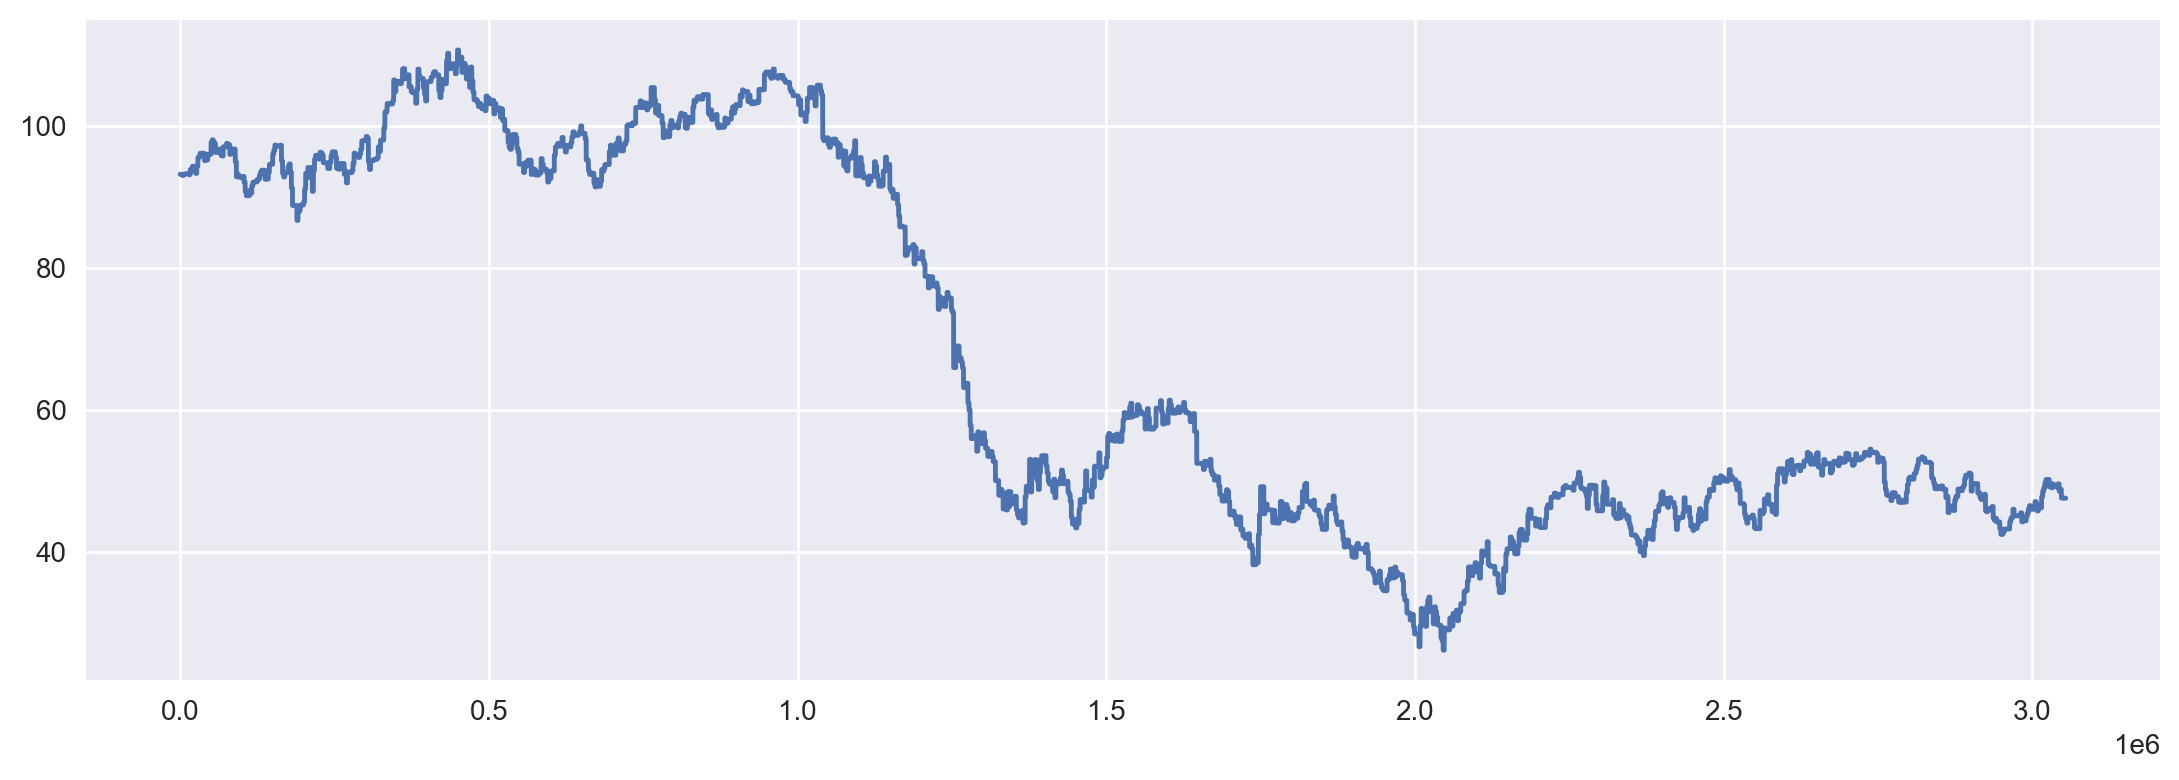

In [29]:
df['oil_price'].plot()

In [30]:
# Confirm that there are no more missing values in the merged dataset

df.isna().sum()


id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
oil_price       0
city            0
state           0
store_type      0
cluster         0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   transactions  float64       
 7   holiday_type  object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  oil_price     float64       
 13  city          category      
 14  state         category      
 15  store_type    category      
 16  cluster       category      
dtypes: category(4), datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 314.6+ MB


In [32]:
df.shape

(3054348, 17)

In [33]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3054348.0,1504276.775379,0.0,754676.75,1507571.5,2255120.25,3000887.0,866261.012008
date,3054348,2015-04-26 12:11:45.717619200,2013-01-01 00:00:00,2014-03-01 00:00:00,2015-04-28 12:00:00,2016-06-22 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,3054348.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3054348.0,359.020892,0.0,0.0,11.0,196.011,124717.0,1107.285897
onpromotion,3054348.0,2.61748,0.0,0.0,0.0,0.0,741.0,12.254939
transactions,3054348.0,1558.655862,0.0,931.0,1332.0,1980.0,8359.0,1036.467605
oil_price,3054348.0,67.7893,26.190001,46.279999,53.189999,95.800003,110.620003,25.702576


#### **Insights from Descriptive Statistics**

- The average oil price within the time frame is 68.02 units, with a minimum oil price of 26.19 units and a maximum of 110.62 units.
- There are 54 stores in the dataset.
- The average sales within the timeframe is 359 units, with a minimum of 0 and maximum of 124717 units, this shows a huge range of values , which contributes to the huge standard deviation of 1107.28 showing how volatile sales was within that timedframe.
- The number of transactions made was either below or above 1332.

In [34]:
#checking the unique values in the categorical columns
for column in df.columns:
    if df[column].dtype == 'object' and column != 'description':
        print(f'Column: {column}\nUnique values: {df[column].unique()}')
        print(70 * '-')


Column: family
Unique values: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
----------------------------------------------------------------------
Column: holiday_type
Unique values: ['Holiday' 'No holiday' 'Work Day' 'Additional' 'Event' 'Transfer'
 'Bridge']
----------------------------------------------------------------------
Column: locale
Unique values: ['National' 'No holiday' 'Local' 'Regional']
----------------------------------------------------------------------
Column: locale_name
Unique values: ['Ecuador' 'No holiday' 'Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamb

### **Feature Engineering**

In [35]:
# Check the unique values of the 'holiday_type' column

df['holiday_type'].unique()

array(['Holiday', 'No holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

In this project, since our focus is on Holidays and non-holidays, we will go ahead and change some the values just to meet our needs.

In [36]:
# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df['holiday_status'] = df['holiday_type'].apply(map_holiday_status)
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [37]:
# Check the unique values of the 'holiday_status' column

df['holiday_status'].unique()

array(['Holiday', 'No holiday'], dtype=object)

In [38]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['dayname'] = df.date.dt.strftime('%A')

df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


In [39]:
# Set the 'date' column as index

df = df.set_index('date')
df.head()

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


Text(0.5, 0, 'Year')

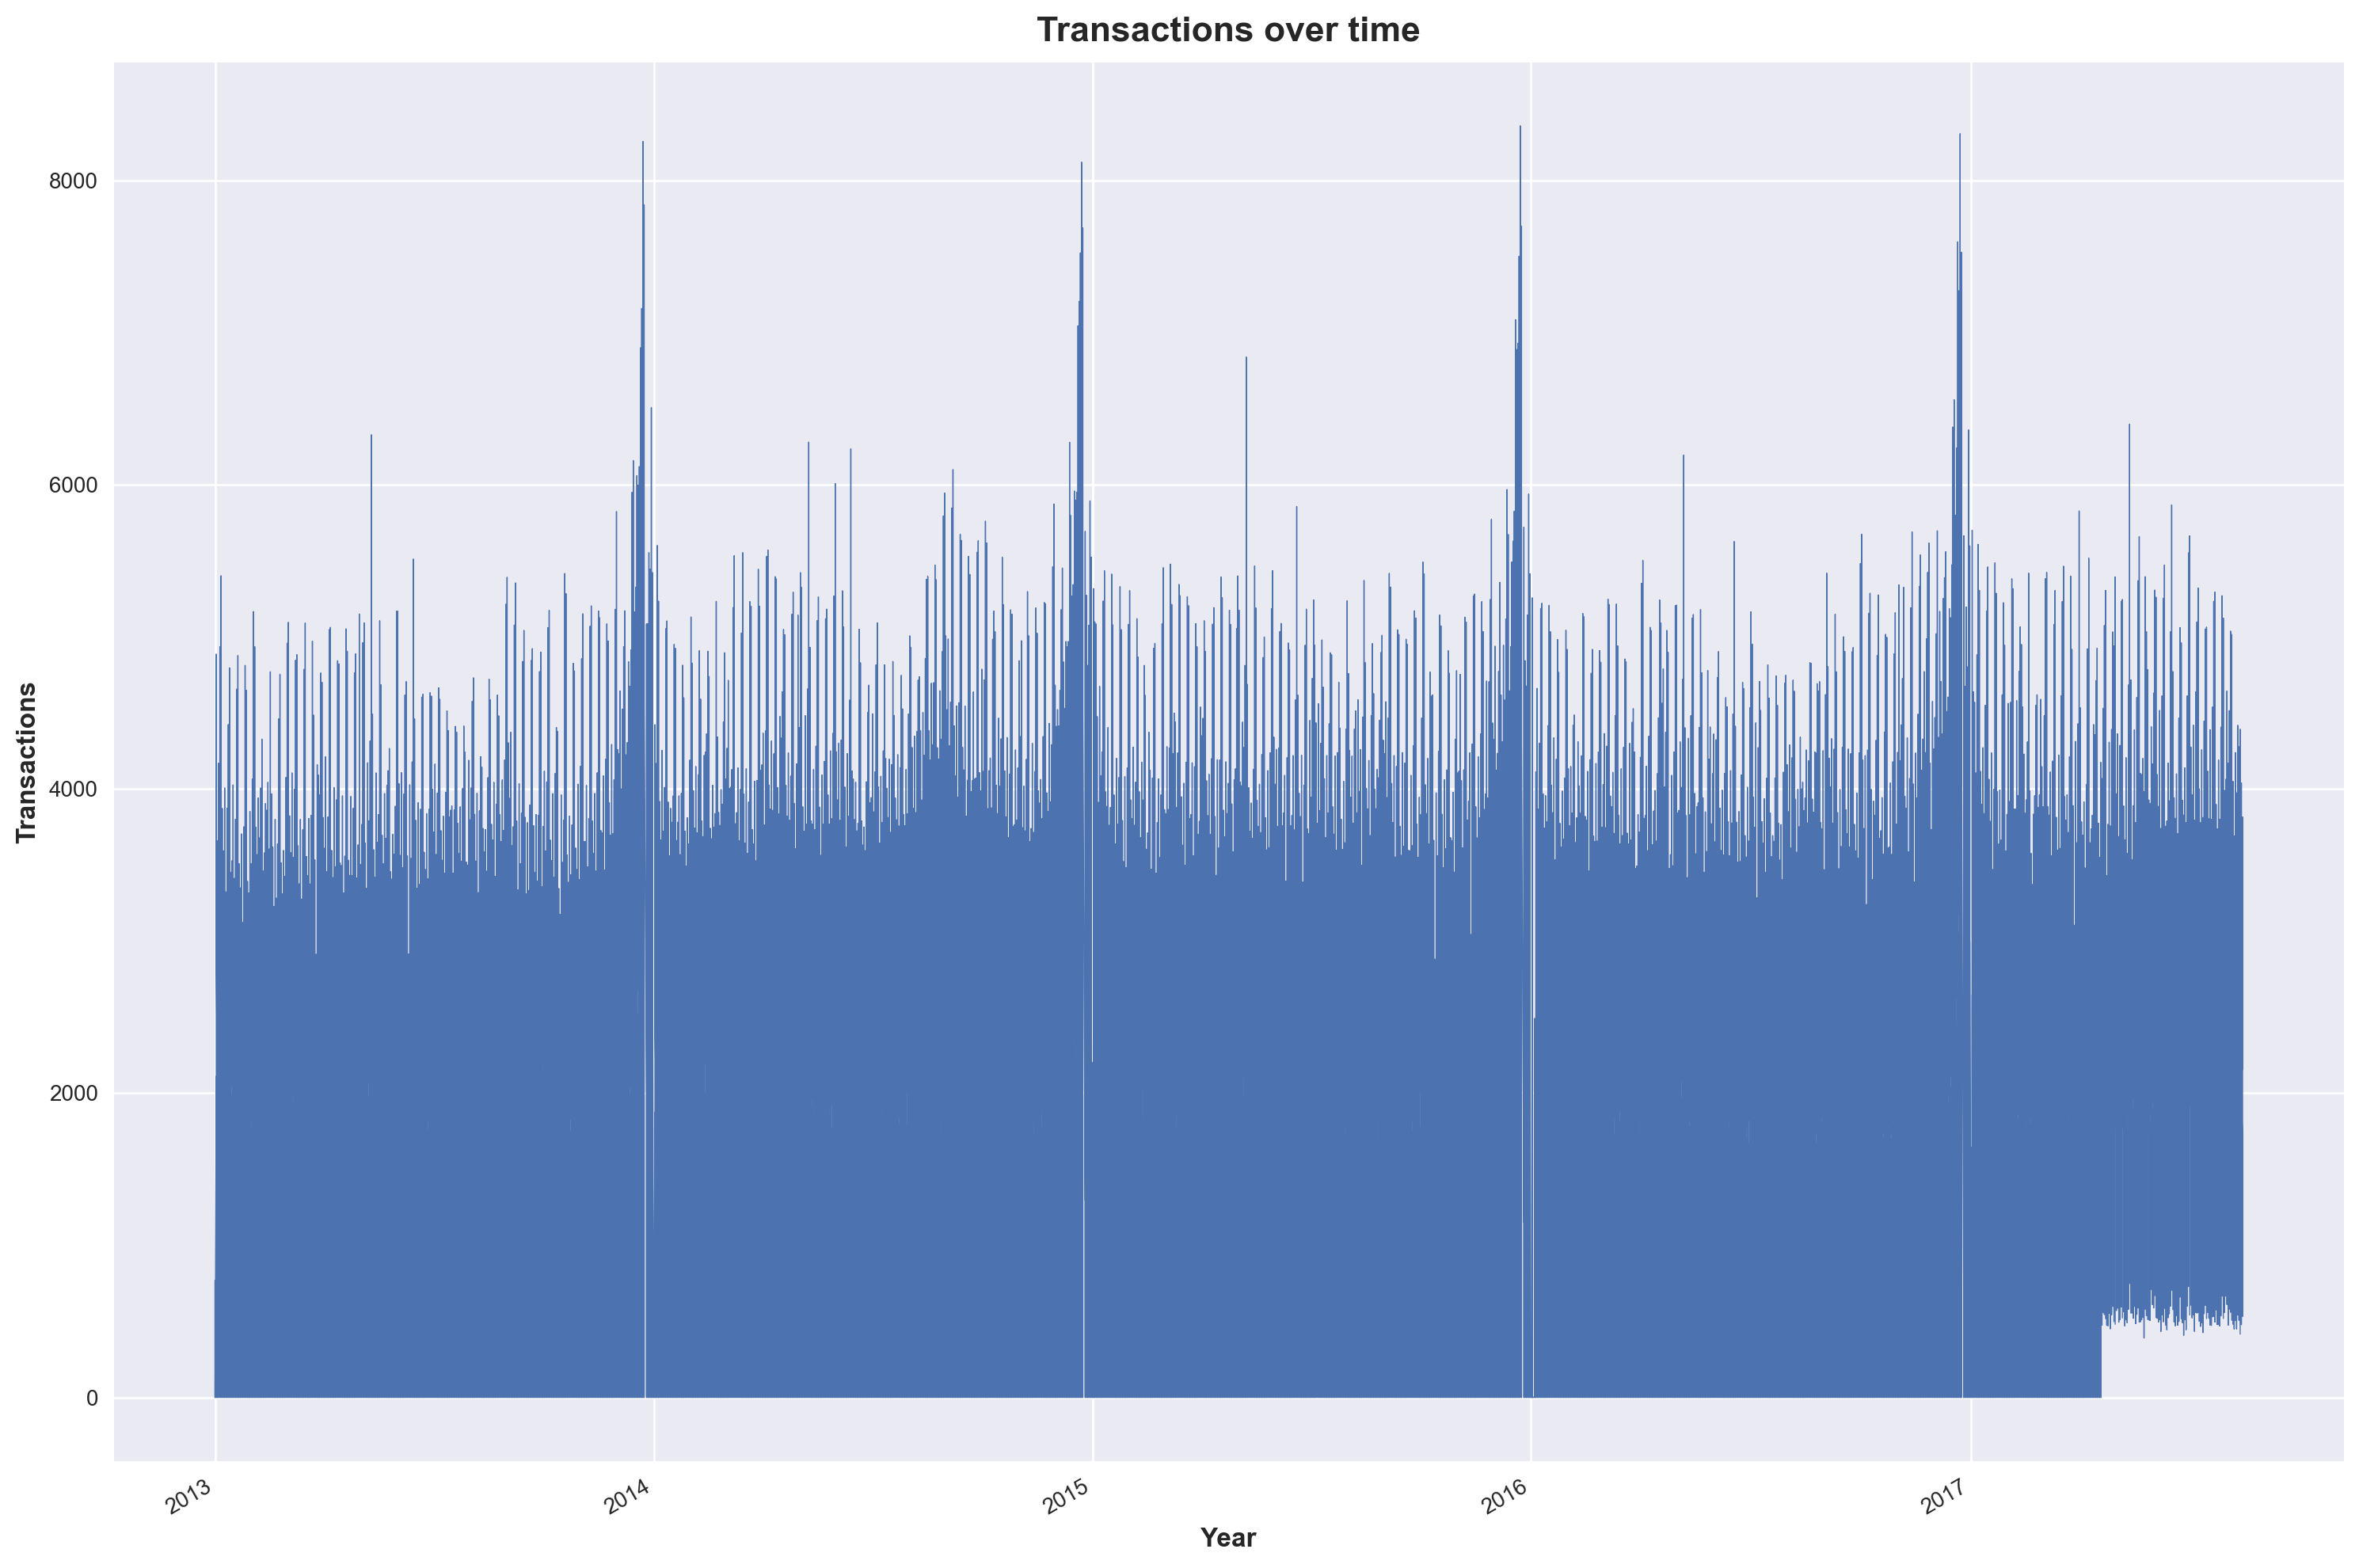

In [40]:
# Visualize the 'transactions' column
plt.figure(figsize=(15,10))
plt.title('Transactions over time')
ax = df['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The transaction plot shows clear seasonal patterns with regular peaks, likely due to holidays or events.
Overall, transaction levels are stable over the years without a significant long-term trend.

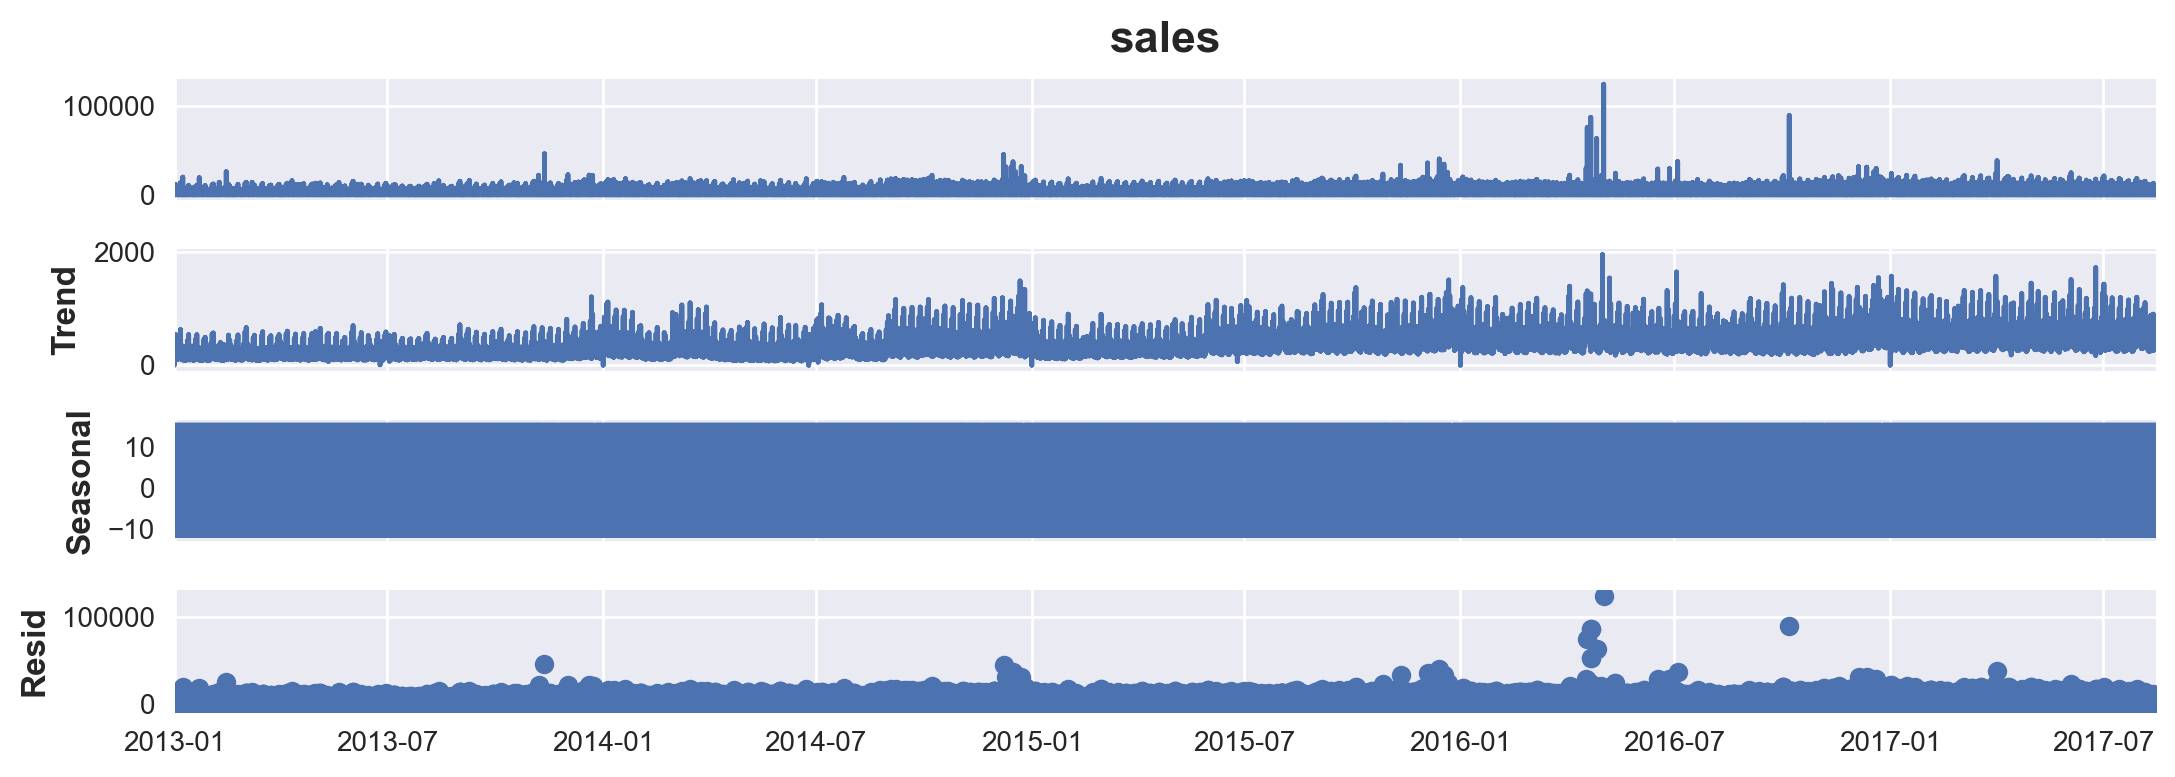

In [41]:
# Perform seasonal decomposition

result = seasonal_decompose(df['sales'], model='additive', period=365)
result.plot()
plt.show()


### Sales:

- The first subplot shows the original observed time series data of sales.
- It represents the total sales over time from 2013 to 2017.
- You can see some spikes and fluctuations in the sales data, indicating periods of high sales and possibly some seasonal patterns.

### Trend:

- The second subplot shows the trend component of the time series.
- The trend represents the long-term movement or direction in the data.
- This component helps to identify the general direction in which sales are moving over time, either upward or downward. From the plot, you can see some upward movement in sales over time with fluctuations.

### Seasonal:

- The third subplot shows the seasonal component of the time series.
- Seasonality refers to the repeating short-term cycle in the data.
- This component captures the regular patterns or cycles within the time series that occur at fixed intervals, such as monthly or yearly patterns. In this plot, the seasonality seems to be quite pronounced, indicating regular seasonal variations in the sales data.

### Residual:

- The fourth subplot shows the residual component of the time series.
- Residuals represent the noise or irregular component of the data after removing the trend and seasonal components.
- This part of the plot shows the remaining fluctuations that cannot be explained by the trend or seasonal components.
- You can see some outliers and random variations in the residual plot.

Overall, this decomposition helps to analyze and understand the underlying patterns in the sales data from Corporacion Favorita. By separating the data into trend, seasonal, and residual components, it becomes easier to model and forecast future sales by addressing each component individually.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

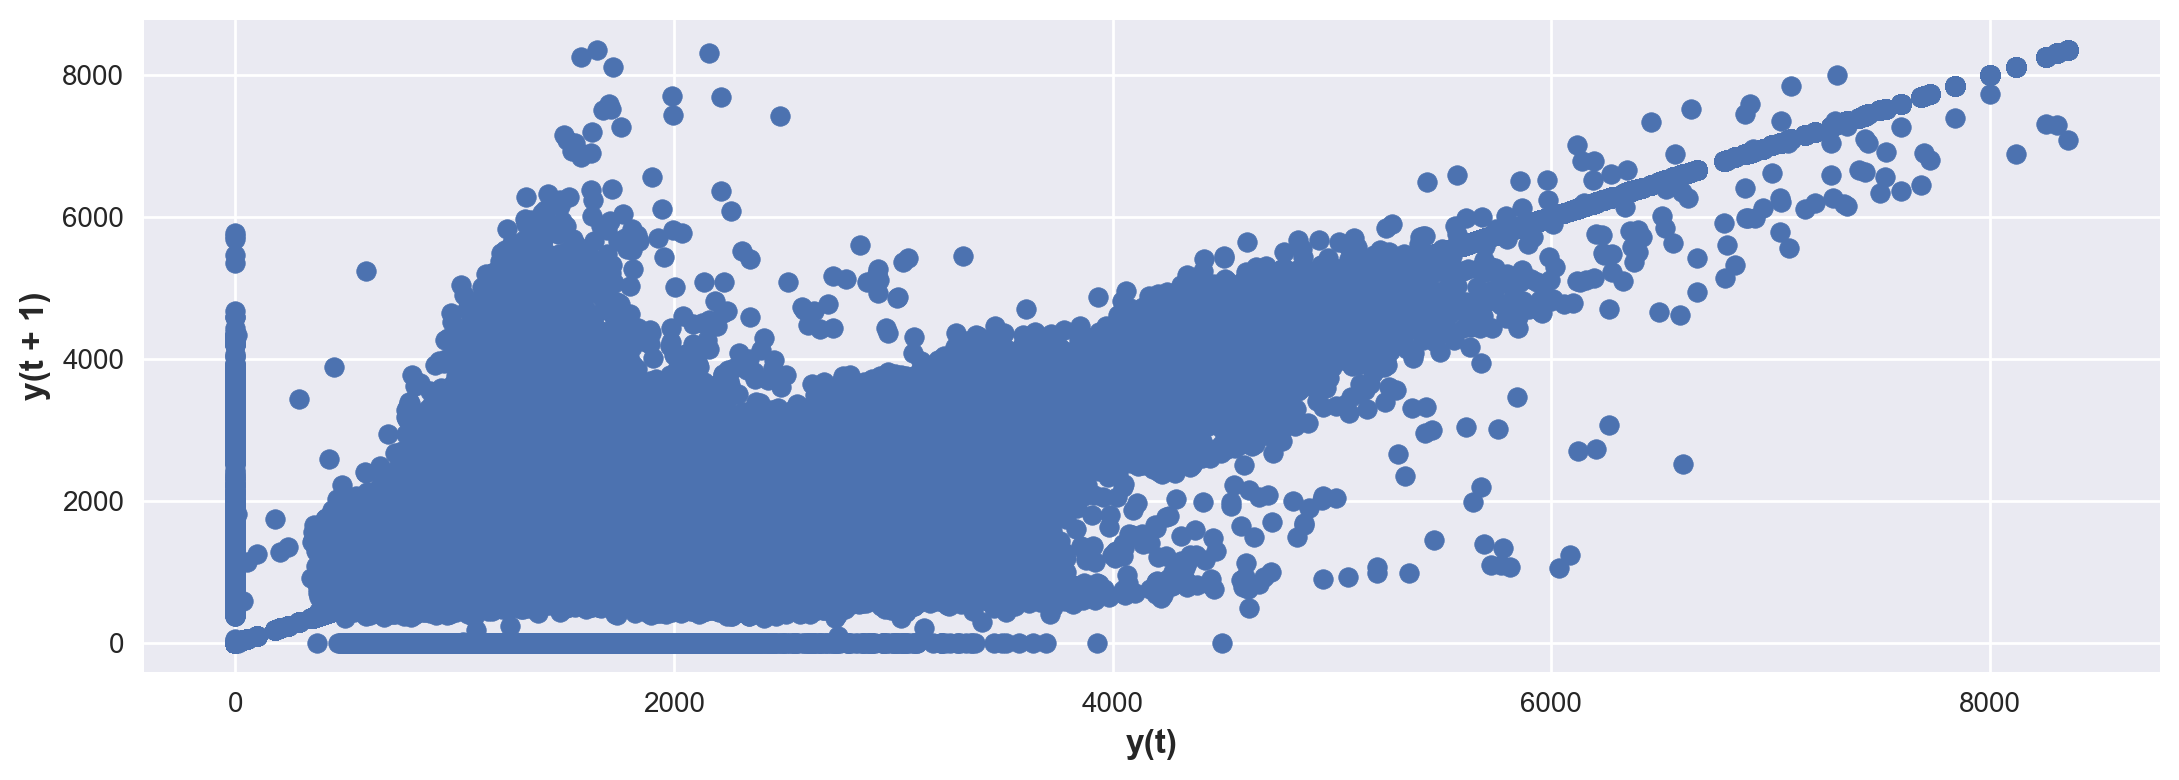

In [42]:
# Create a lag plot

pd.plotting.lag_plot(df['transactions'], lag=1)


A lag plot is a graphical tool used in time series analysis to examine the autocorrelation or serial correlation in a dataset. Autocorrelation refers to the correlation between a time series and a lagged version of itself, which can provide valuable insights into the underlying structure of the data. The lag plot helps in visualizing autocorrelation, identifying seasonality, assessing stationarity, model selection, detecting serial correlation, and checking residuals.

The lag plot above for our dataset reveals that there is clustering, linearity, and a few pattern deviations in the plot.

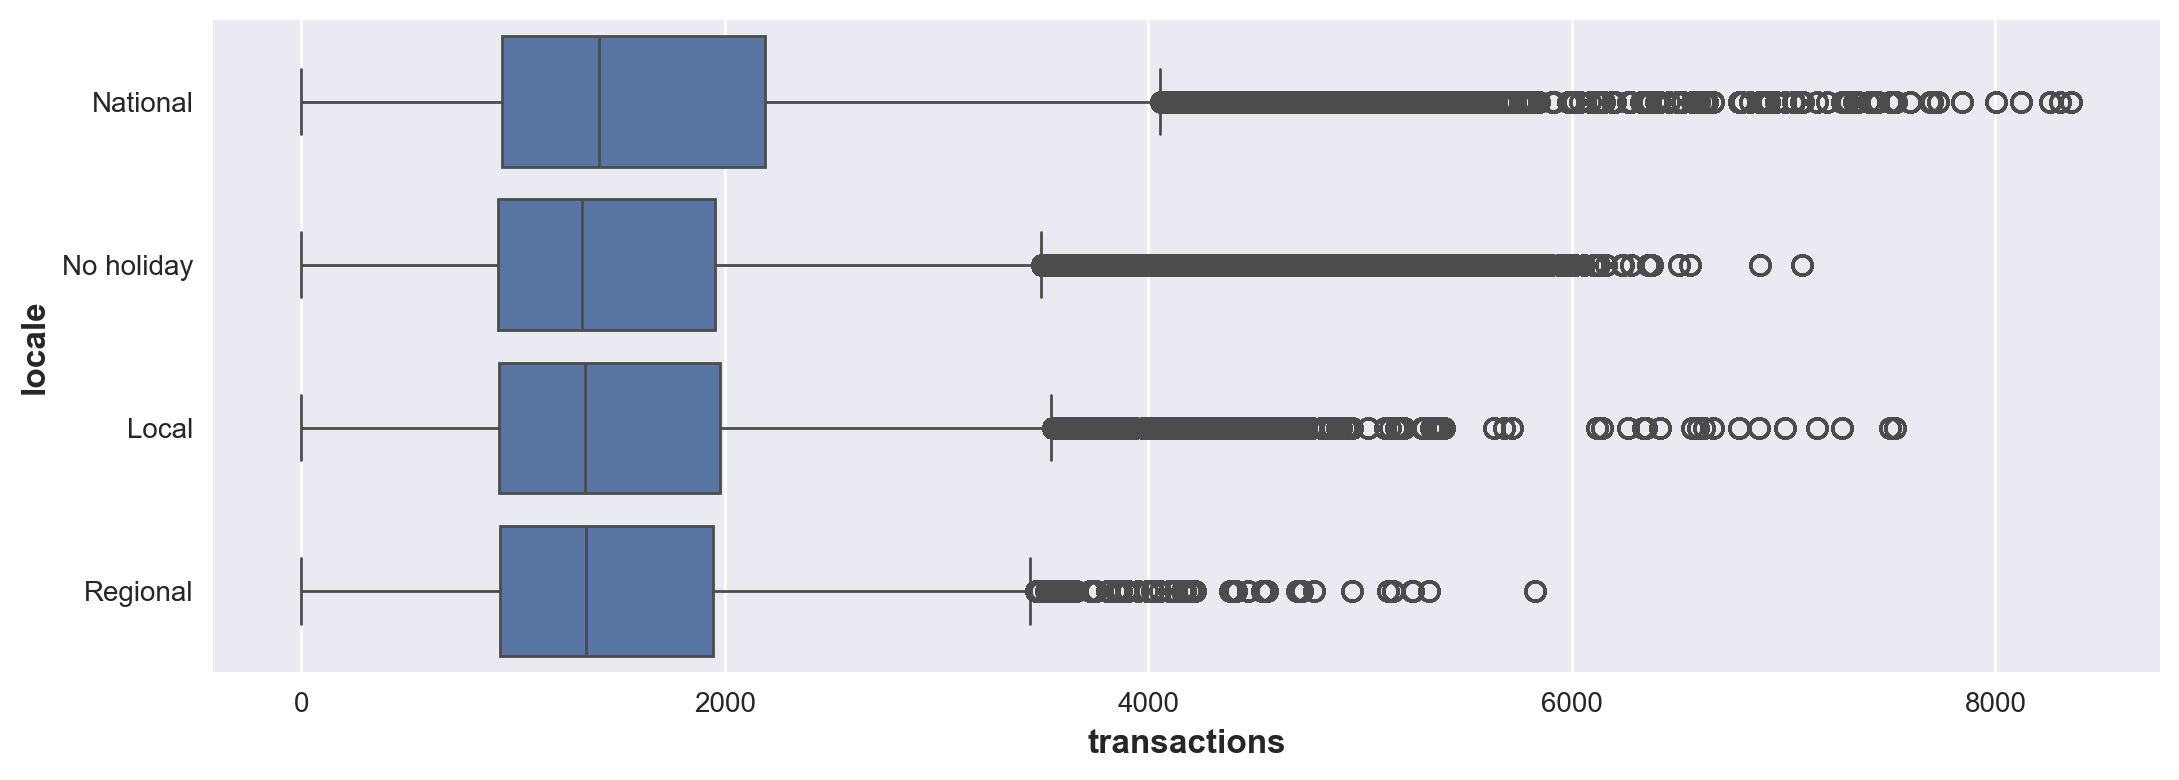

In [43]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=df)

# Show the plot
plt.show()

For the box plot above, the median (the line within the box) shows the central tendency of the data and is highest for 'National holidays'. Also, the length of the boxes show that 'transactions' on National Holidays have the greatest variability as it has the longest box. The data points that fall outside the whiskers of all the boxes indicate extreme values (outliers) or anomalies with 'National holidays' having the most extreme values.

Based on the boxplot, there is evidence of significant variations in transaction patterns between locales.

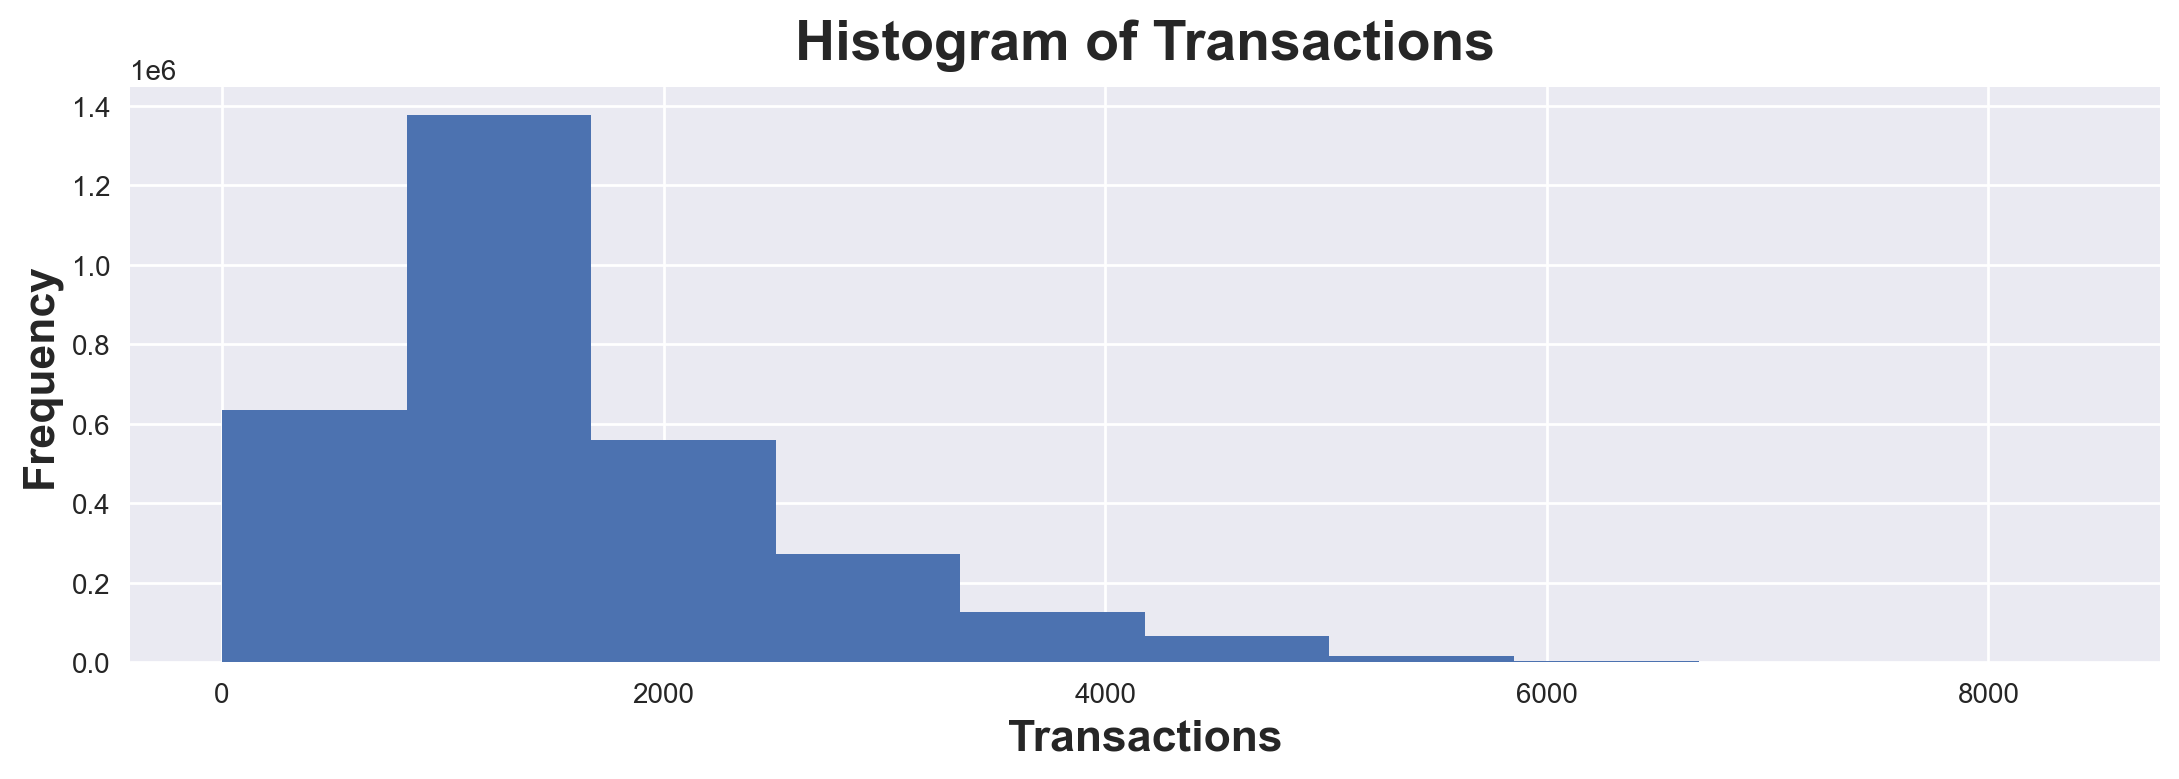

In [44]:
# Create a histogram of the 'transactions' column
df.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)


# Show the plot
plt.show()

The histogram plot shows that most transactions fall within a range around 800 to 1800. However, the presence of outliers may need further investigation. There is also a steady fall in the frequency of the transactions suggesting a steady transaction pattern.

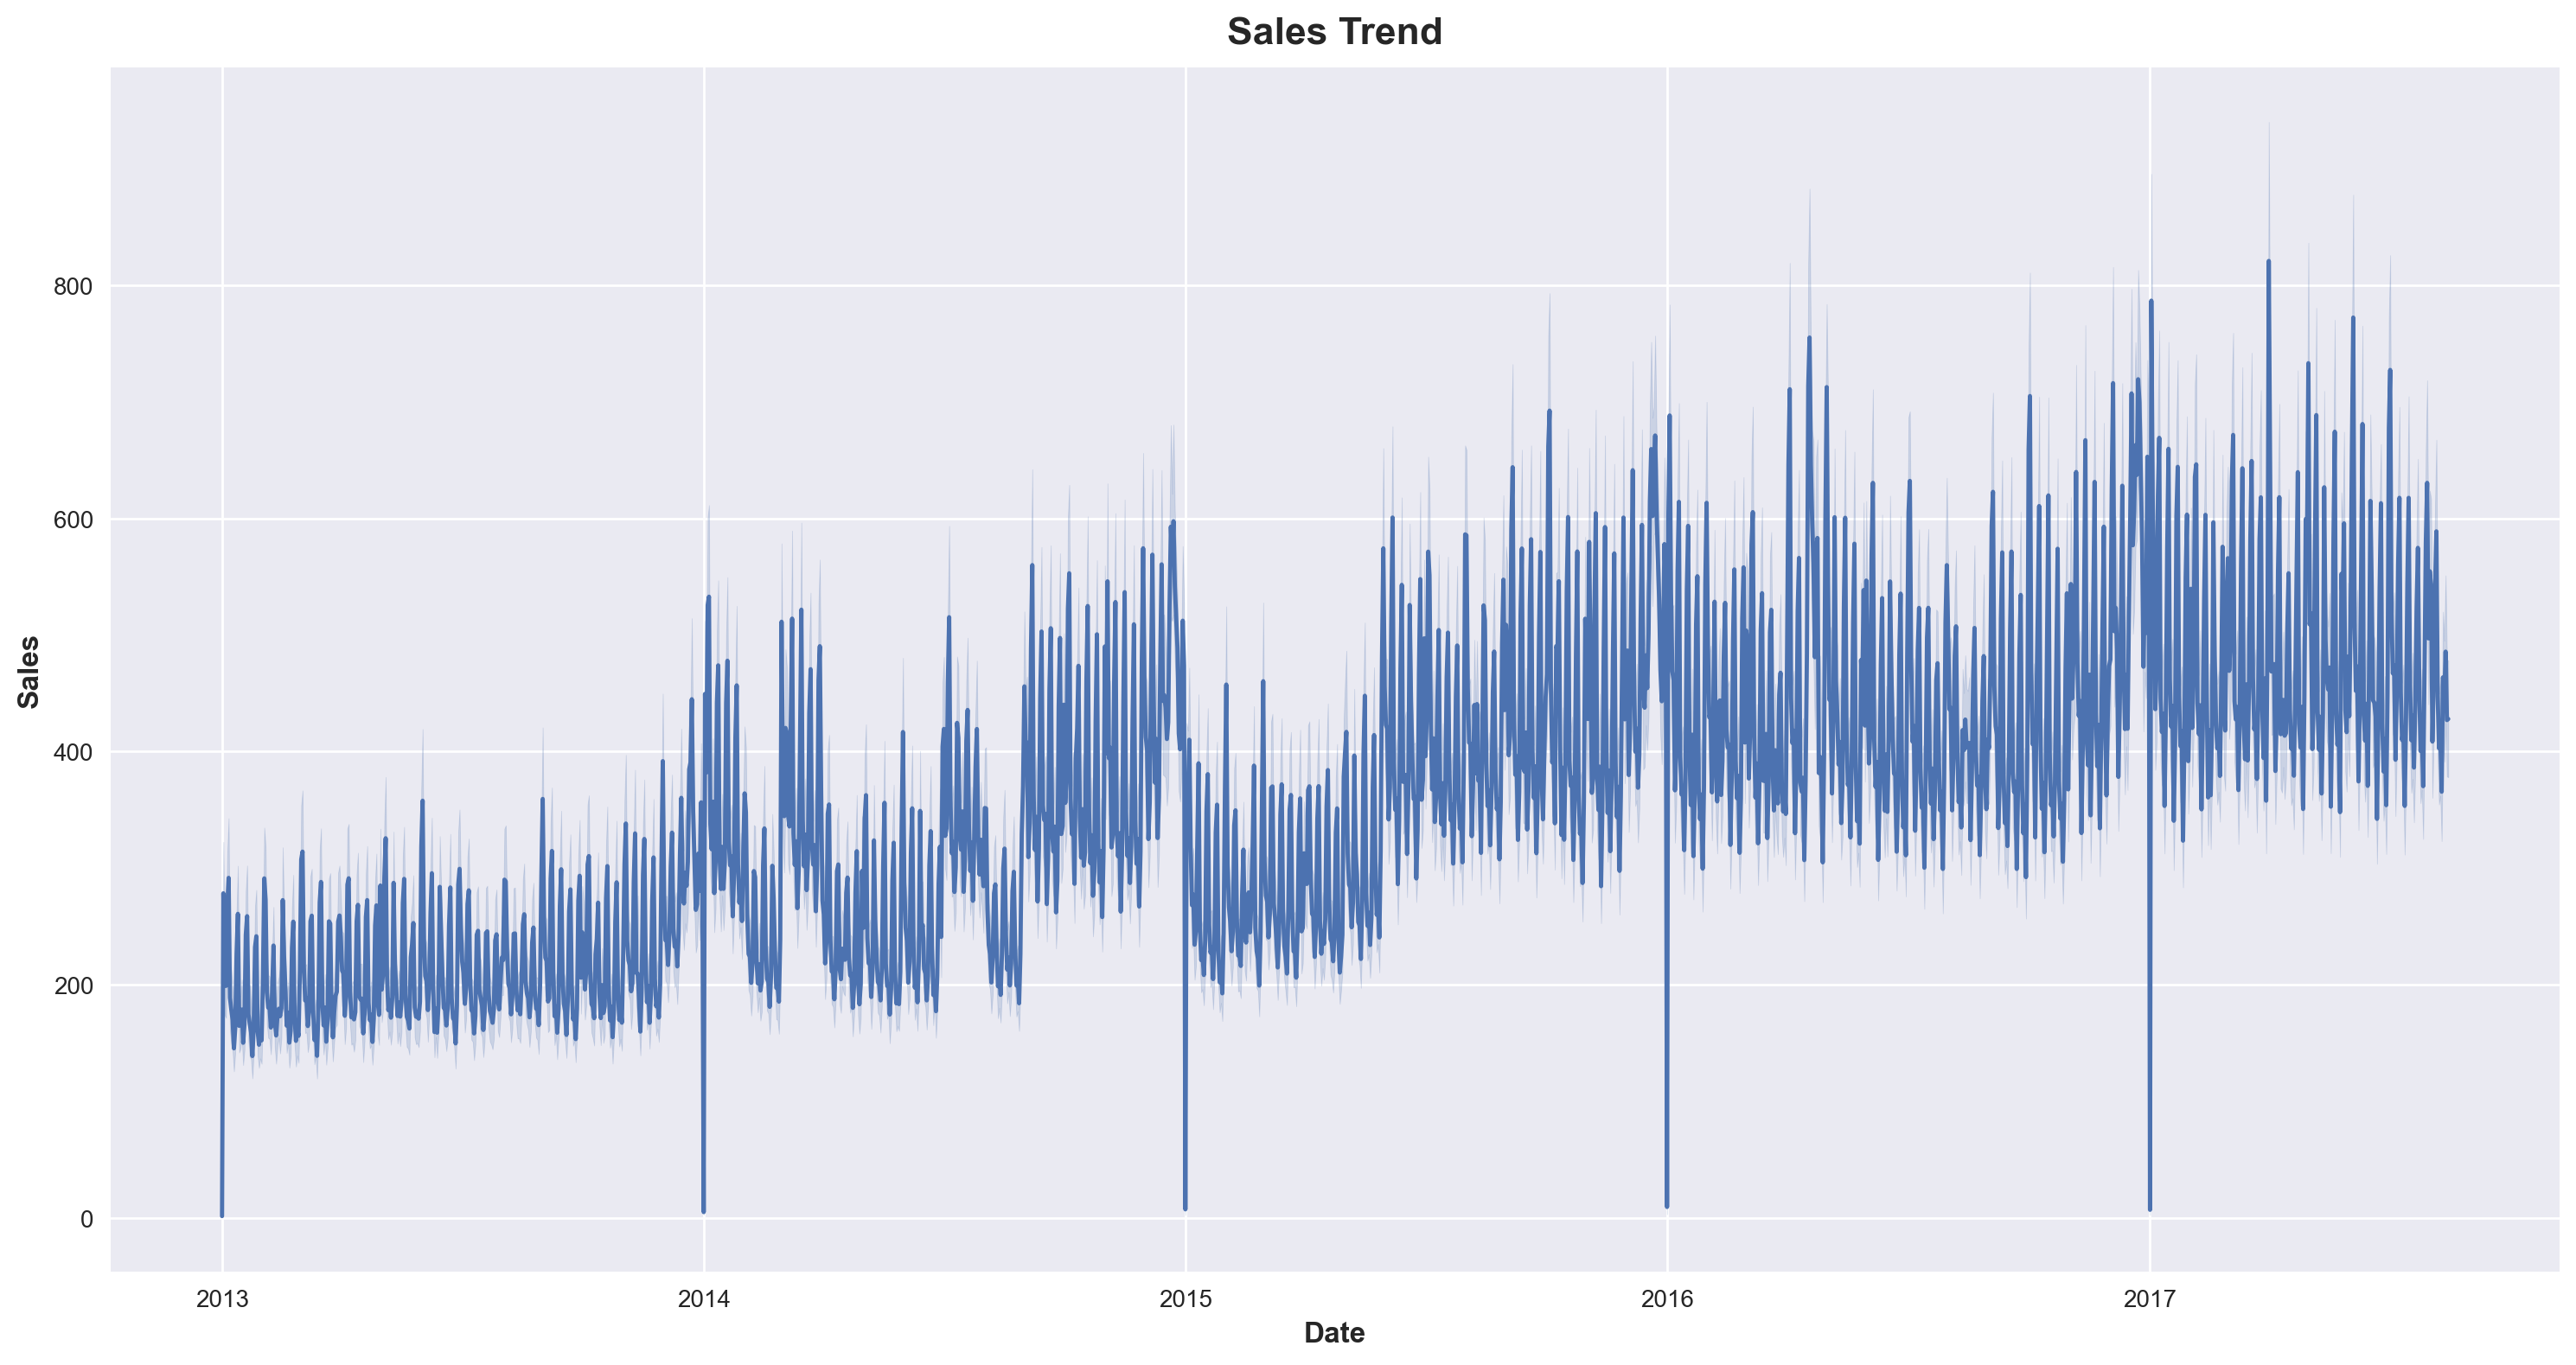

In [45]:
#sales trend
plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='sales', data=df)
plt.title('Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')


plt.show()

The sales trend above shows that there is an upward trend in the sales over the years. It also shows that there are more sales at the end of each year, which starts dropping beginning of the other year.

<Axes: >

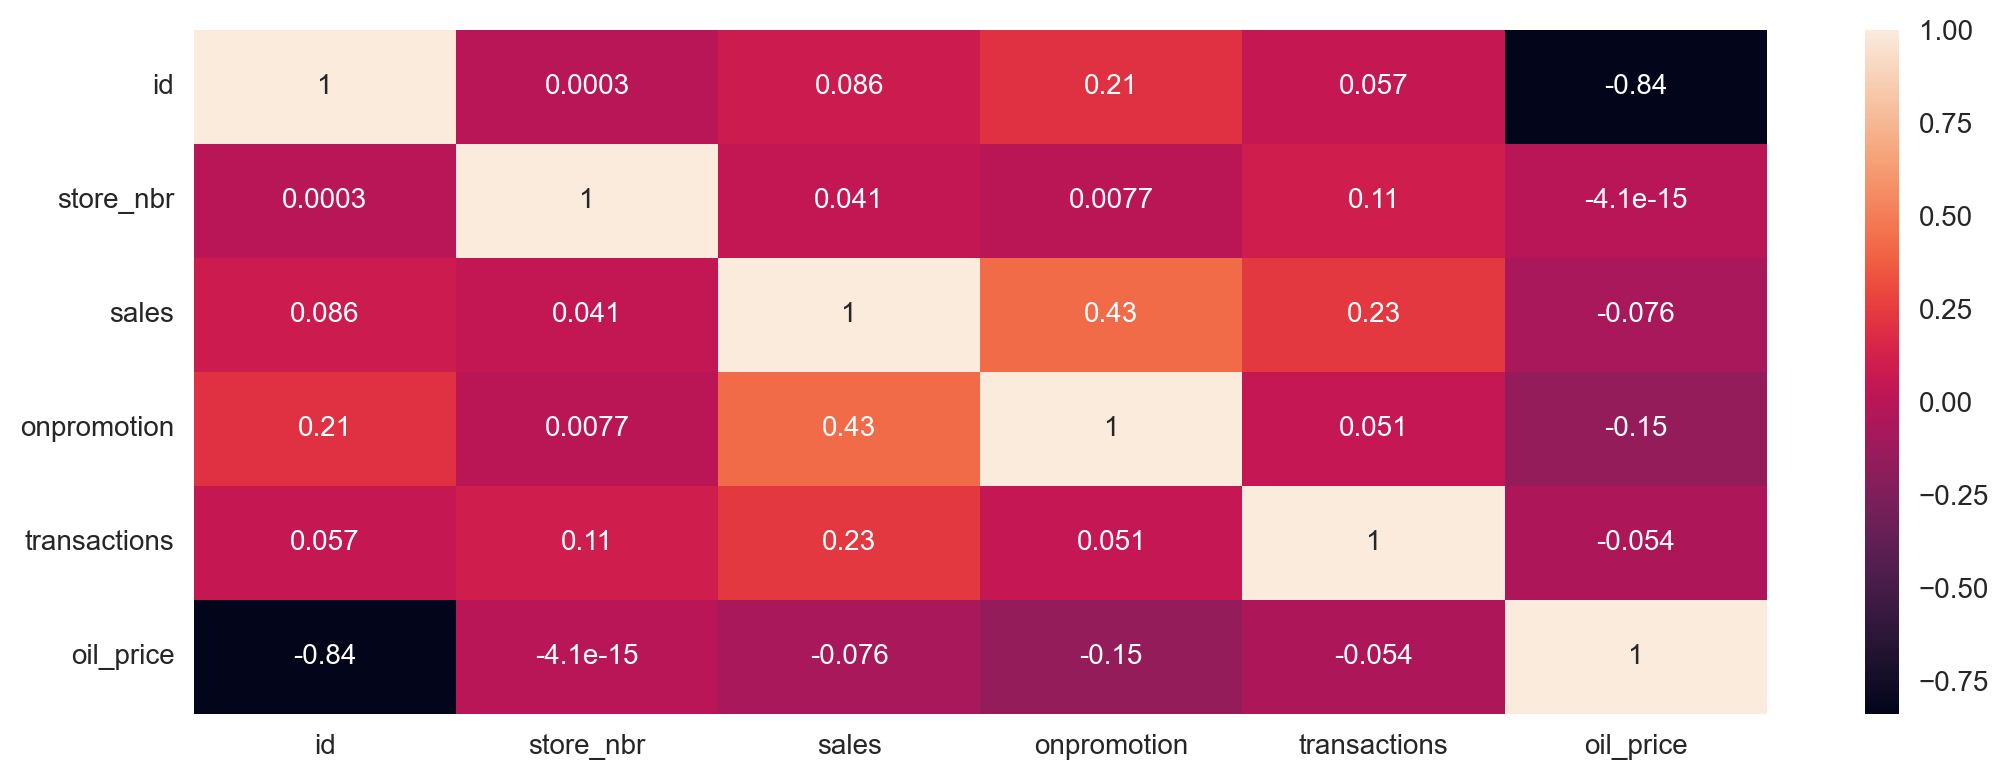

In [46]:
# Create a DataFrame of train_data with numerical columns only
train_data_num = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_data_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

### Hypothesis Testing

Null Hypothesis(HO): There is no changes in sales before and after promotion.

Alternate Hypothesis(H1): There is changes in sales before and after promotion.

In [47]:
# Extract sales data before and after promotion
before_promotion = df[df['onpromotion'] == 0]['sales']
after_promotion = df[df['onpromotion'] == 1]['sales']

# Check normality with Shapiro-Wilk test
stat, p_before = shapiro(before_promotion)
stat, p_after = shapiro(after_promotion)

print('Before Promotion: p-value =', p_before)
print('After Promotion: p-value =', p_after)

# If data is normally distributed, use t-test
if p_before > 0.05 and p_after > 0.05:
    stat, p_value = ttest_ind(before_promotion, after_promotion)
    test_used = "Two-sample t-test"
else:
    # If data is not normally distributed, use Mann-Whitney U test
    stat, p_value = mannwhitneyu(before_promotion, after_promotion)
    test_used = "Mann-Whitney U test"

print(f'{test_used}: p-value =', p_value)

# Conclusion
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant change in sales before and after promotion.')
else:
    print('Fail to reject the null hypothesis: There is no significant change in sales before and after promotion.')


c:\Users\Kwame Yeboah\OneDrive\Desktop\Career Accelerator\LP-3 Favorita Time Series\Stores-Sales-prediction\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 2428528.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Kwame Yeboah\OneDrive\Desktop\Career Accelerator\LP-3 Favorita Time Series\Stores-Sales-prediction\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 178763.
  res = hypotest_fun_out(*samples, **kwds)


Before Promotion: p-value = 1.062896908595753e-236
After Promotion: p-value = 1.0754786892614463e-177
Mann-Whitney U test: p-value = 0.0
Reject the null hypothesis: There is a significant change in sales before and after promotion.


At a significance level of 5%, there is enough evidence to conclude that promotion influenced sales.

### Test for Stationarity

In [48]:
# Perform the KPSS test
kpss_result = kpss(df['sales'], regression='c')

# Print the test results
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

# Conclusion
if kpss_result[1] < alpha:
    print('Reject the null hypothesis: The time series is not stationary.')
else:
    print('Fail to reject the null hypothesis: The time series is stationary.')


KPSS Statistic: 147.99573100272488
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis: The time series is not stationary.


C:\Users\Kwame Yeboah\AppData\Local\Temp\ipykernel_18160\2532915316.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['sales'], regression='c')


As confirmed by the KPSS test, the time series is not stationary.

### Answering Analytical questions

1. Is the train dataset complete (has all the required dates)?


In [49]:
# Check the range of the date column
dates_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Check for missing dates in the dataset
missing_dates = set(dates_range.date) - set(df.index.unique())

# Create a new dataframe with the dates_missing data
missing_dates_df = pd.DataFrame(missing_dates)
missing_dates_df.head()

,0
0,2013-04-06
1,2014-11-16
2,2017-03-17
3,2016-02-11
4,2013-01-30


As seen, the dataset is incomplete, there are some missing dates in the dataset.


2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

The dates where the sales made is 0 are most likely the dates that the outlets of the retail store were not open. Such days are not considered as dates with the lowest sales because the store was not even open for sales at all.

In [50]:
# Group the data by year
grouped_data = df.groupby('year')

# Find the dates with the highest and lowest sales for each year, excluding the dates with zero sales
years = []
max_dates = []
max_sales = []
min_dates = []
min_sales = []

for year, group in grouped_data:
    nonzero_sales_group = group[group['sales'] > 0]
    if not nonzero_sales_group.empty:
        max_sale_date = nonzero_sales_group['sales'].idxmax()
        min_sale_date = nonzero_sales_group['sales'].idxmin()
        max_sale_value = nonzero_sales_group['sales'].max()
        min_sale_value = nonzero_sales_group['sales'].min()

        years.append(year)
        max_dates.append(max_sale_date)
        max_sales.append(max_sale_value)
        min_dates.append(min_sale_date)
        min_sales.append(min_sale_value)

# Create the result DataFrame
result_data = {
    'Year': years,
    'Highest_Sales_Date': max_dates,
    'Highest_Sales': max_sales,
    'Lowest_Sales_Date': min_dates,
    'Lowest_Sales': min_sales
}
result_df = pd.DataFrame(result_data)
result_df

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,2013-11-12,46271.000,2013-08-06,0.122
1,2014,2014-12-08,45361.000,2014-12-05,0.188
2,2015,2015-12-14,40351.460,2015-09-15,0.196
3,2016,2016-05-02,124717.000,2016-06-23,0.396
4,2017,2017-04-02,38422.625,2017-02-09,0.426


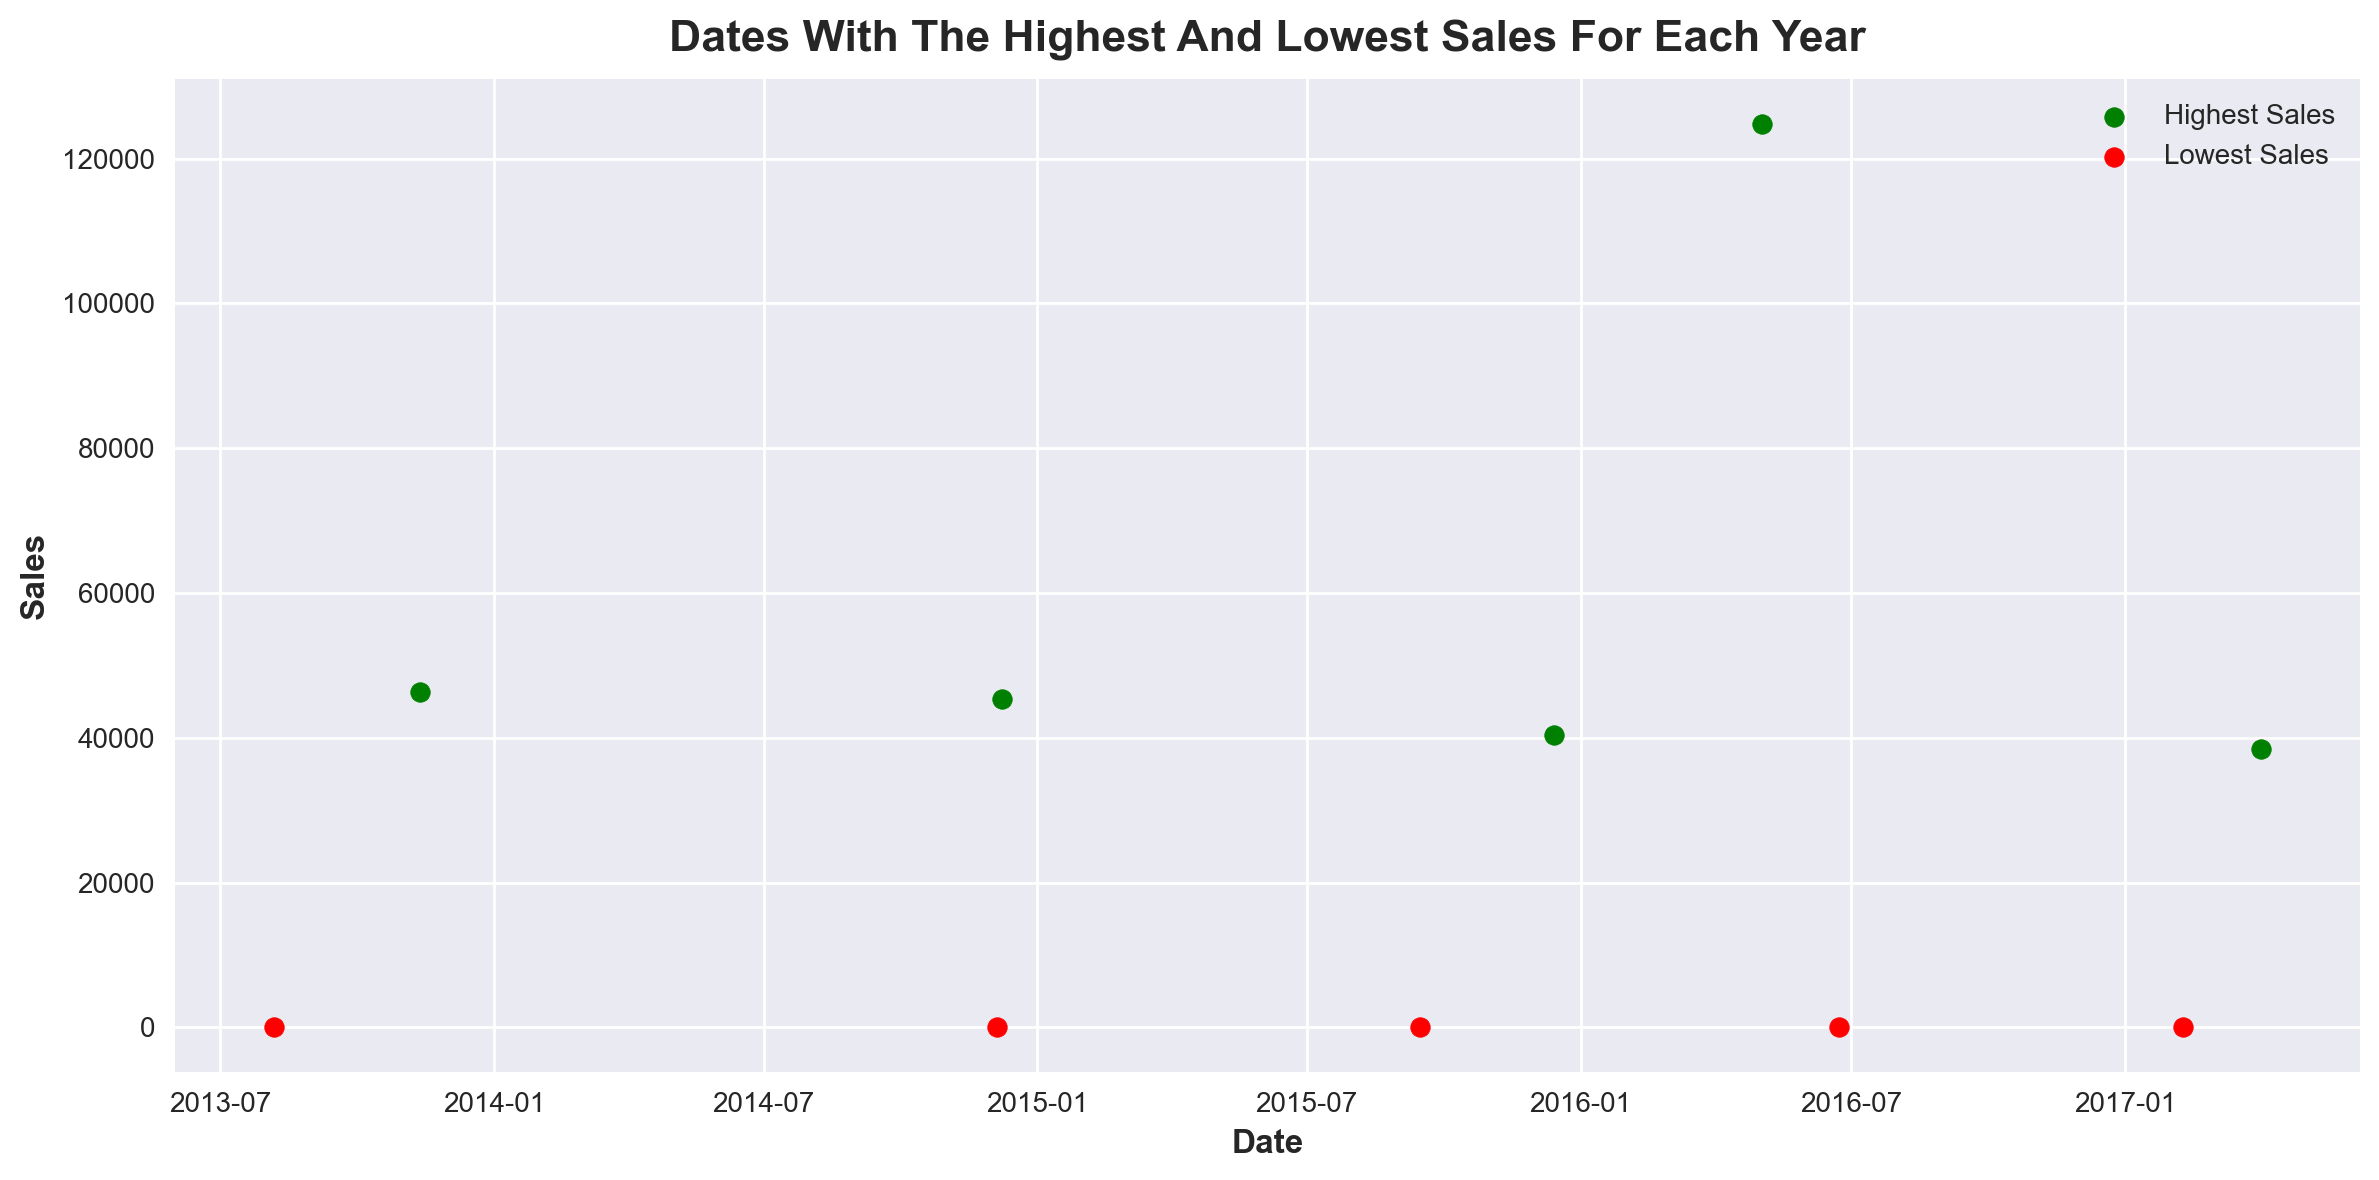

In [51]:
# Visualize the dates that have the lowest and highest sales for each year on a chart

plt.figure(figsize=(12, 6))
plt.scatter(result_df['Highest_Sales_Date'], result_df['Highest_Sales'], color='green', label='Highest Sales', marker='o')
plt.scatter(result_df['Lowest_Sales_Date'], result_df['Lowest_Sales'], color='red', label='Lowest Sales', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.title('Dates With The Highest And Lowest Sales For Each Year')

# Display the plot
plt.show()

3. Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [52]:
result_df

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,2013-11-12,46271.000,2013-08-06,0.122
1,2014,2014-12-08,45361.000,2014-12-05,0.188
2,2015,2015-12-14,40351.460,2015-09-15,0.196
3,2016,2016-05-02,124717.000,2016-06-23,0.396
4,2017,2017-04-02,38422.625,2017-02-09,0.426


In [53]:
result_df[result_df['Highest_Sales'] ==  result_df['Highest_Sales'].max()]

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
3,2016,2016-05-02,124717.0,2016-06-23,0.396


The 5th month(May) of 2016, had the highest sales

4. Did the earthquake impact sales?


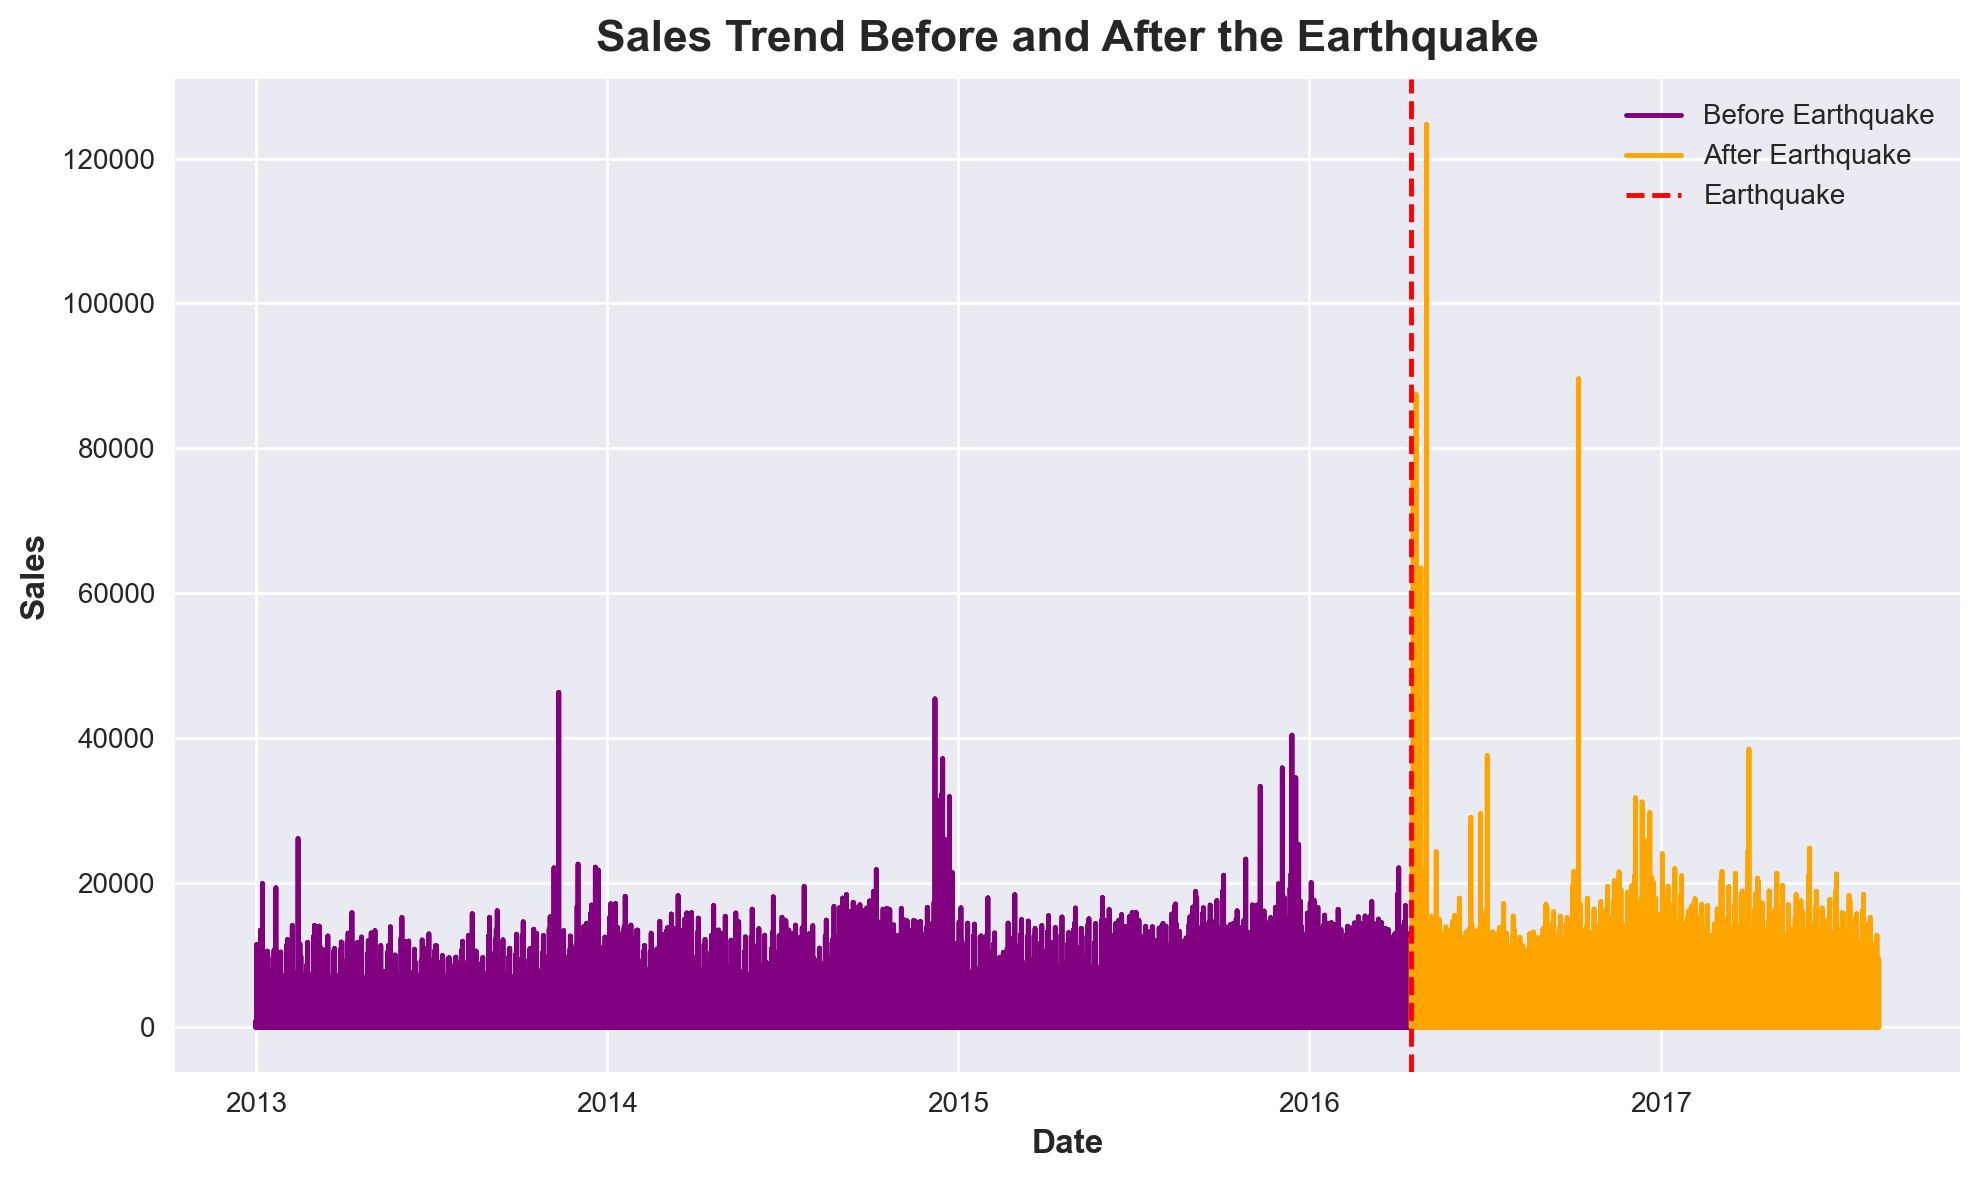

In [54]:
# Convert 'date' from index to a regular column
df.reset_index(inplace=True)

# Filter the data for the period before and after the earthquake
before_earthquake_df = df[df['date'] < '2016-04-16']
after_earthquake_df = df[df['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df['date'], before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

# Revert 'date' back to an index
df.set_index('date', inplace=True)

As observed from the plot, there was a significant increase in sales immediately after the earthquake. This surge could be attributed to people stocking up on food to stay indoors following the earthquake. Another reason might be that hospitals and emergency services needed to purchase large amounts of supplies to cater to earthquake victims.

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

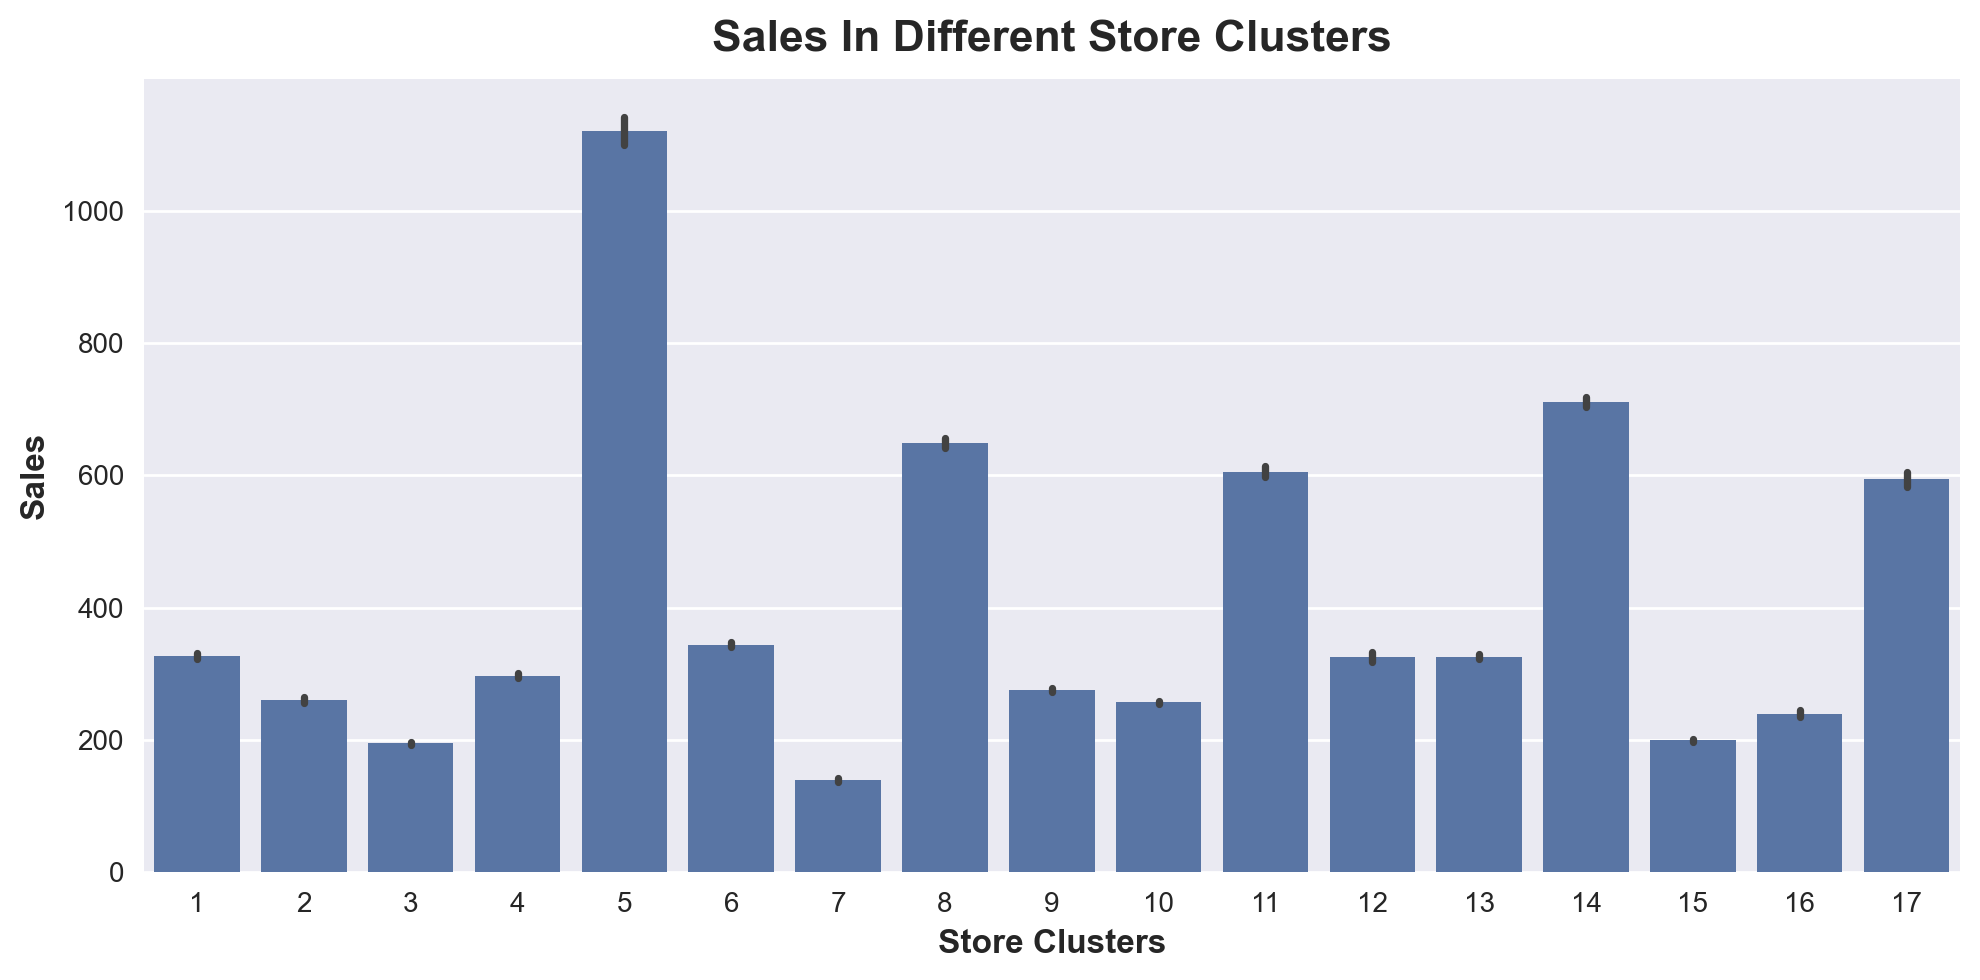

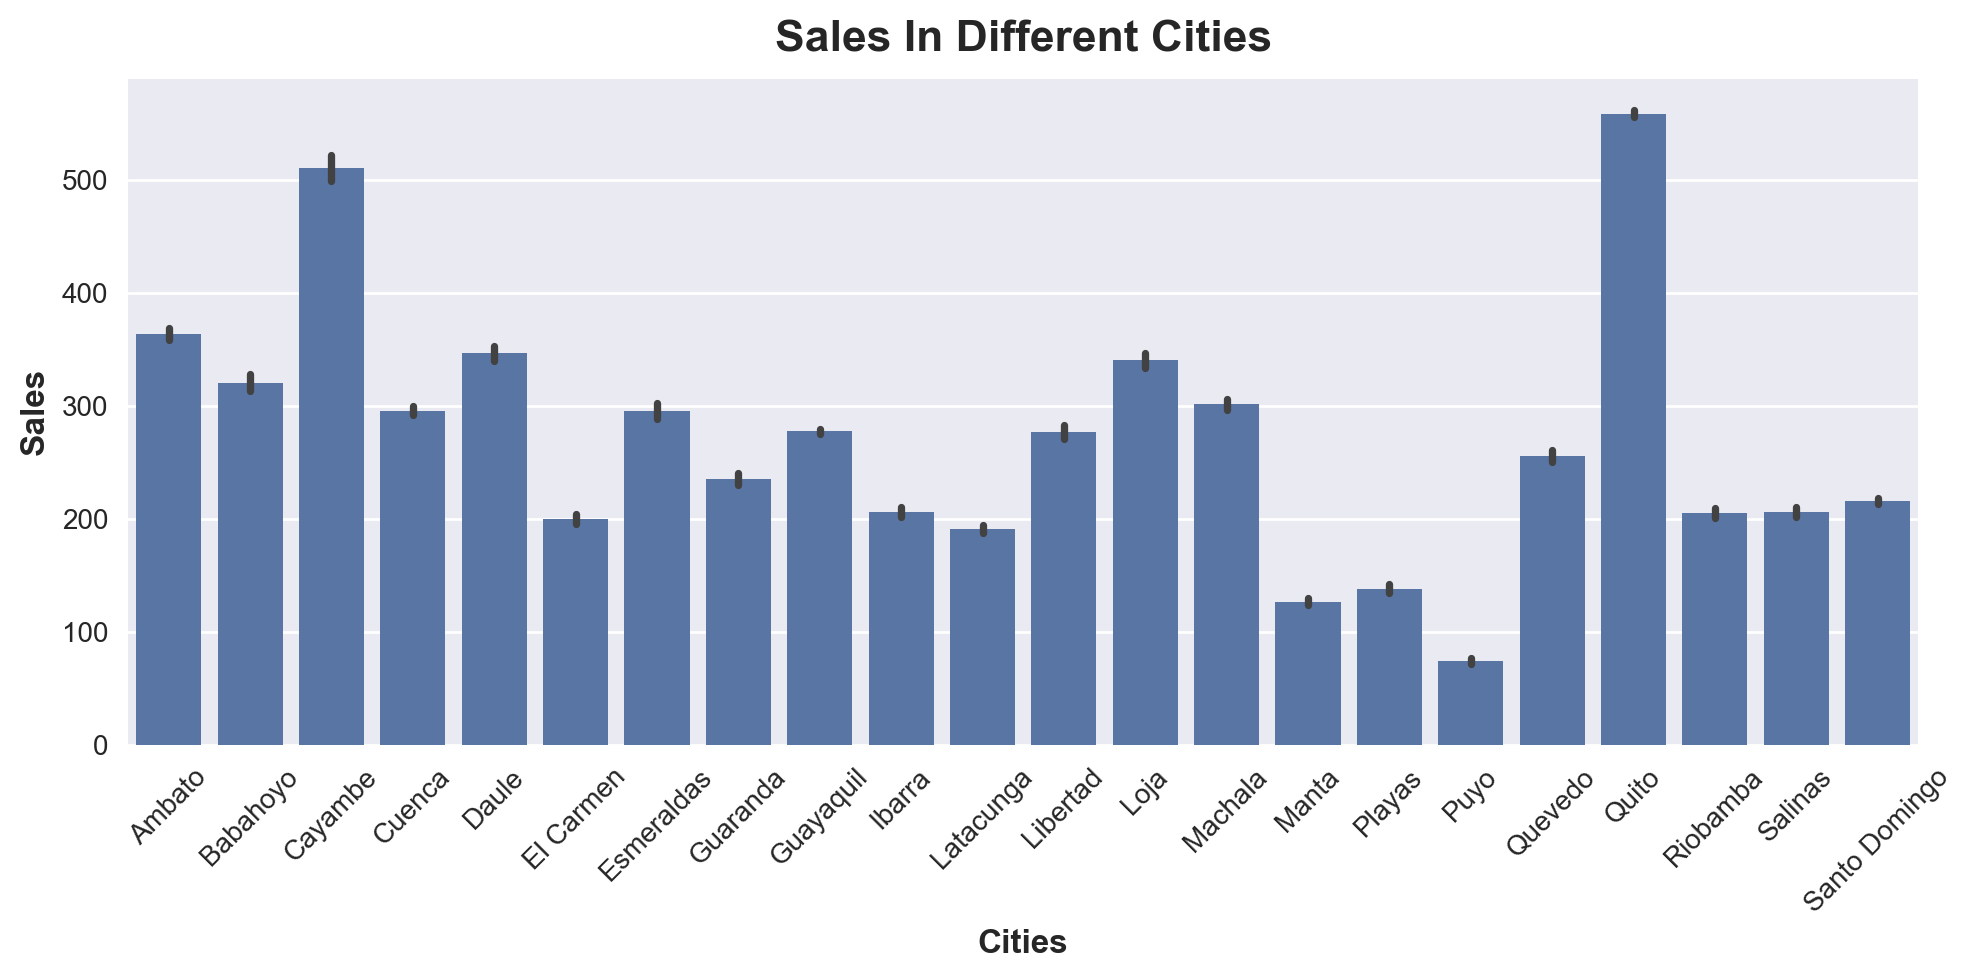

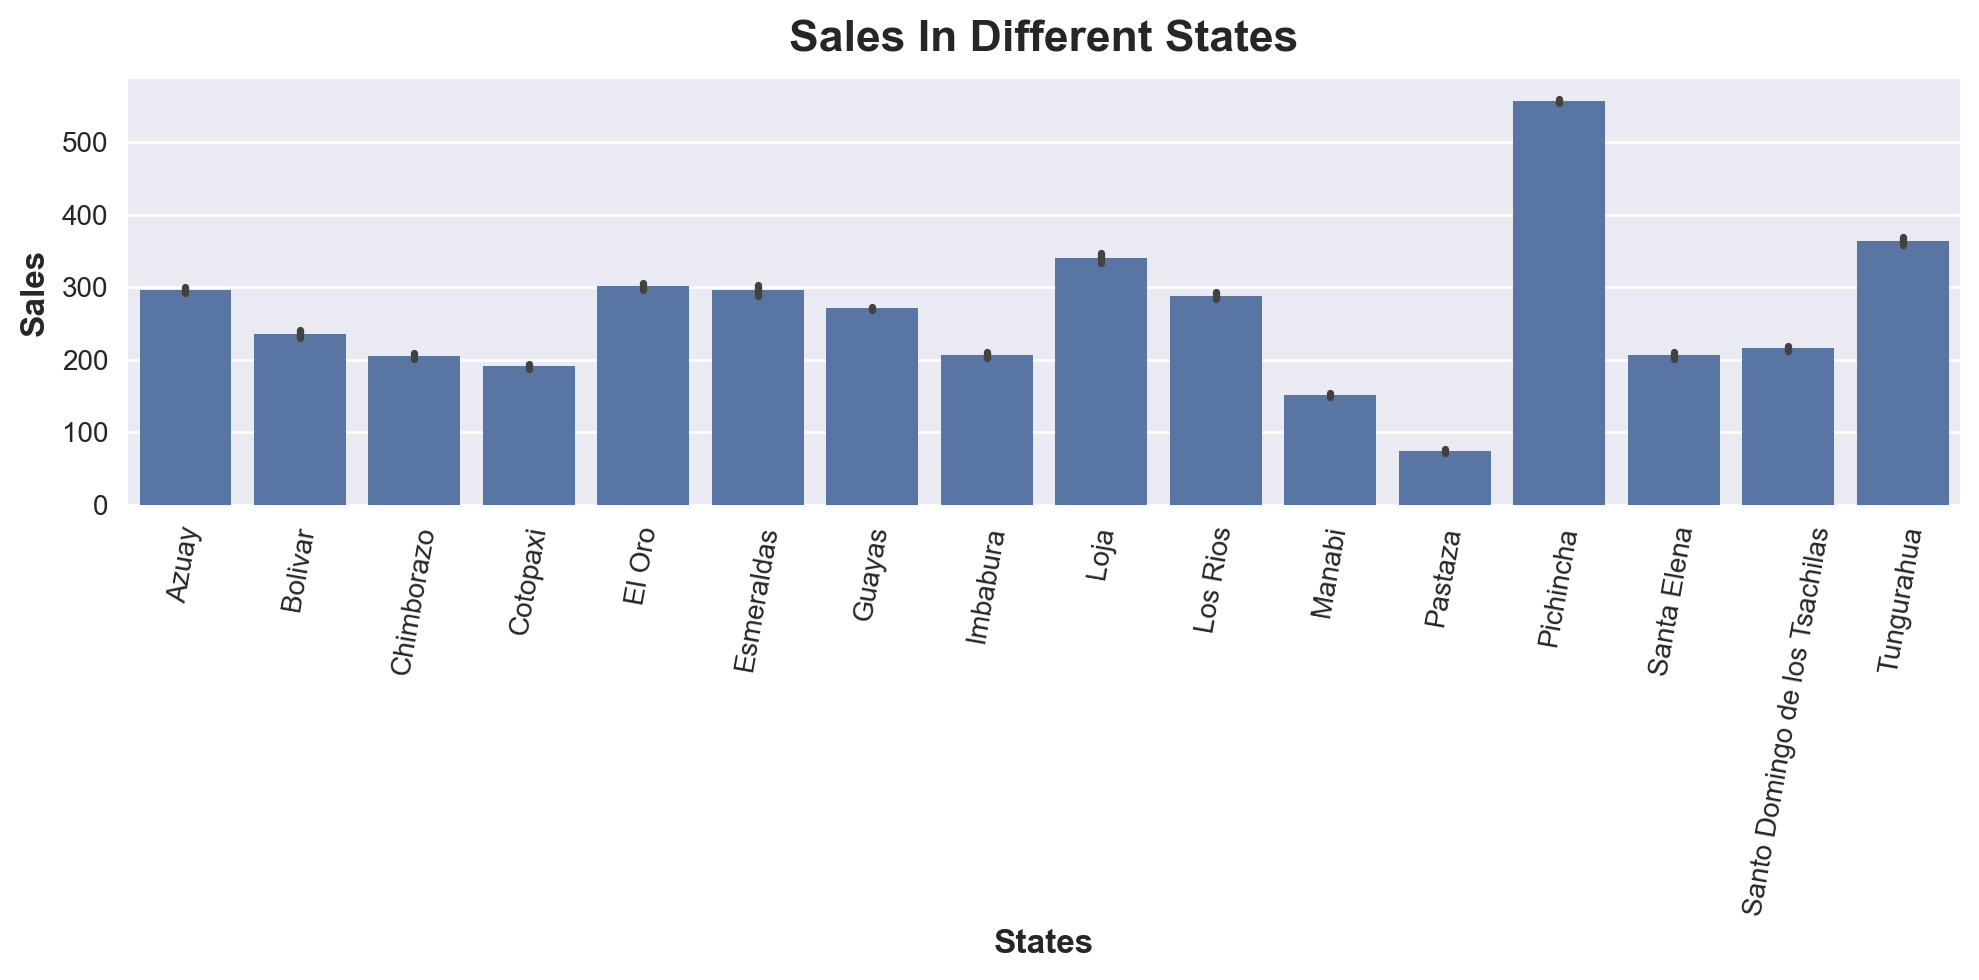

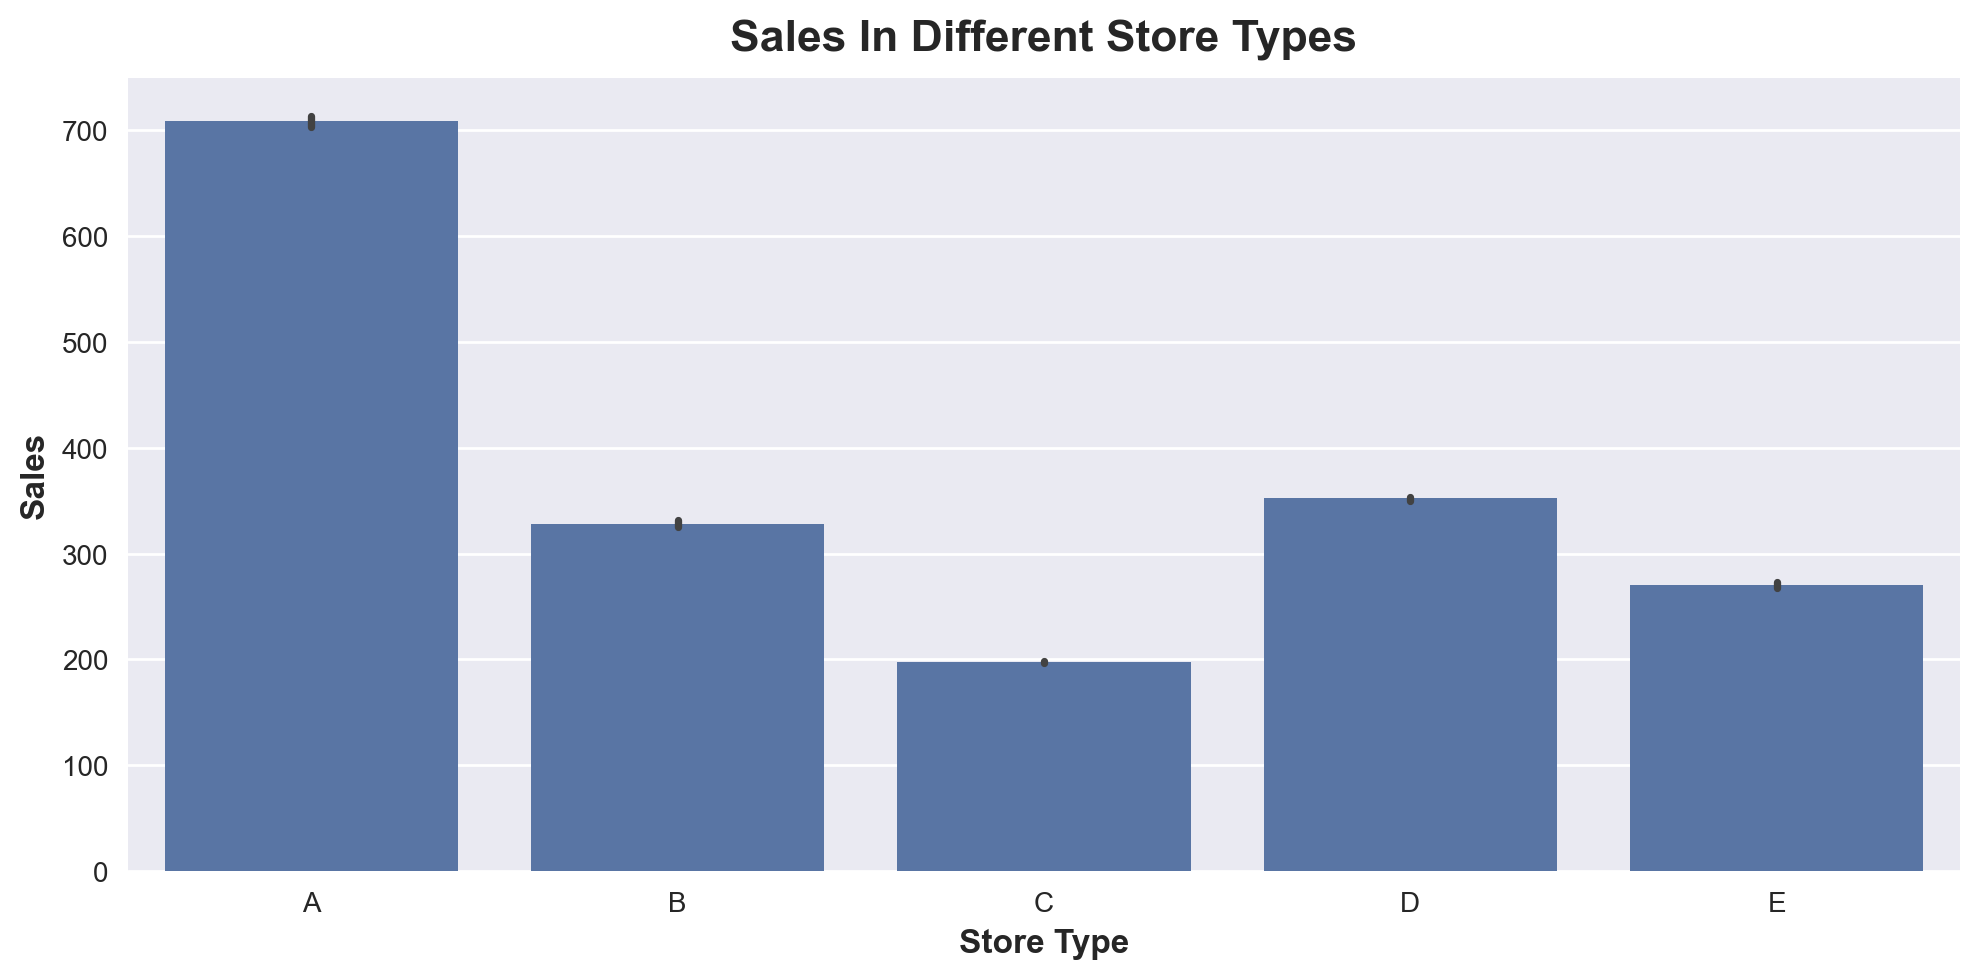

In [55]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=df)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=df)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

# Compare the sales in different states

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=df)
plt.title('Sales In Different States')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=df, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

As seen from the 4 plots, some groups of stores are making more sales than other stores

6. Are sales affected by promotions, oil prices and holidays?

Text(0, 0.5, 'Sales')

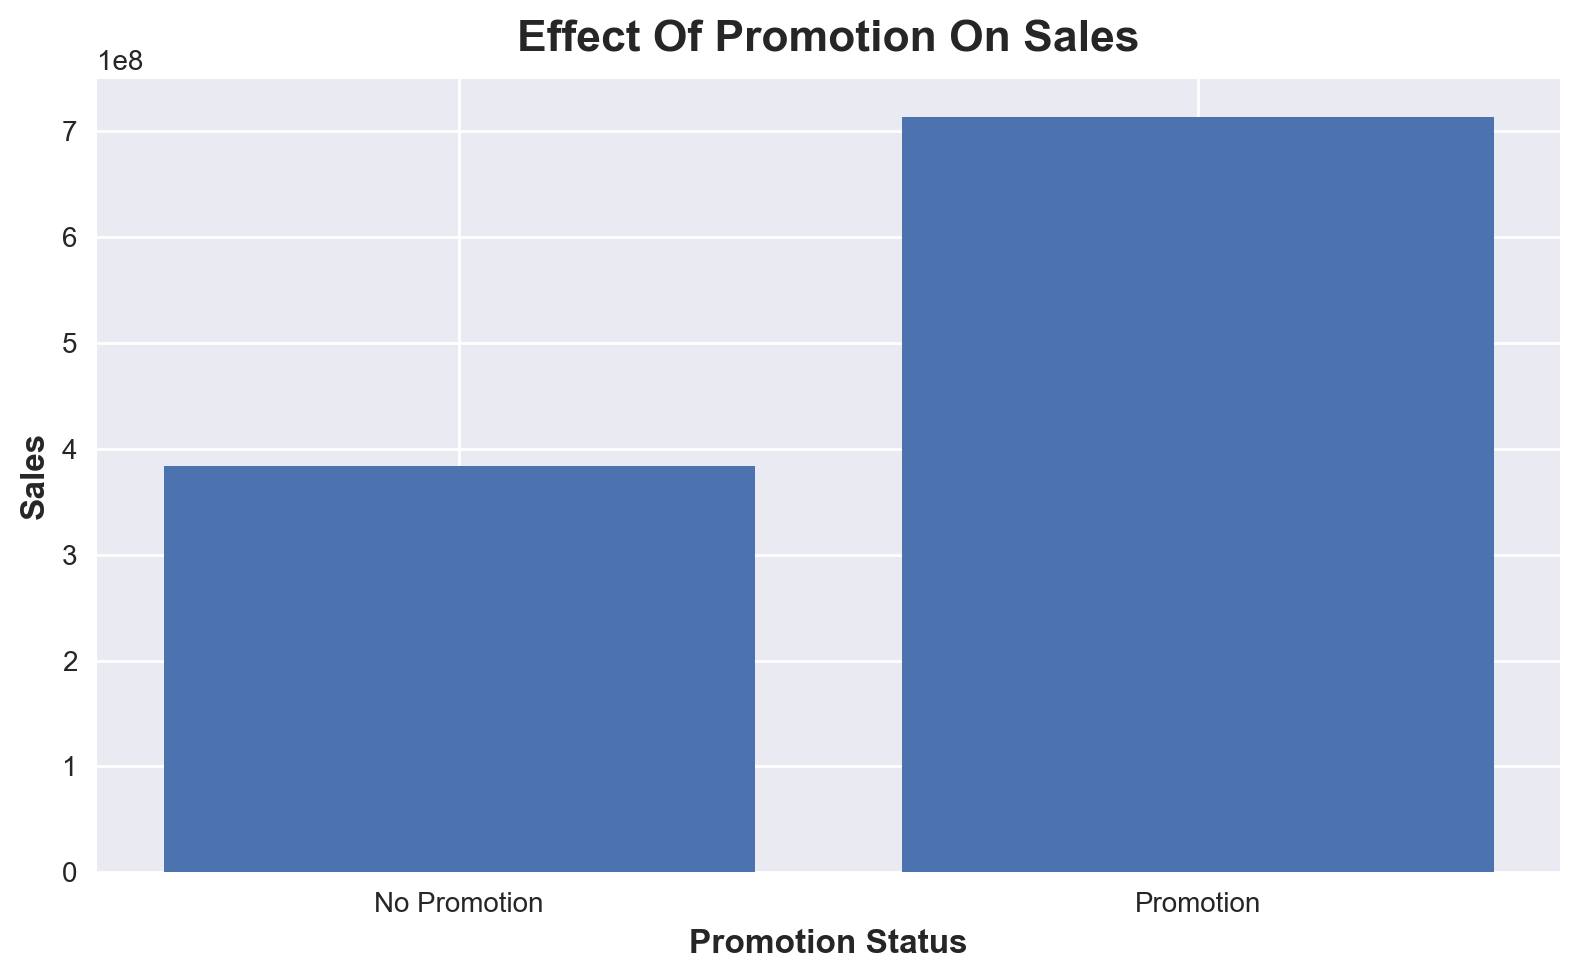

In [56]:
# Identify families with at least one item on promotion and families with no item on promotion
df['promotion_status'] = df['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = df.groupby(['promotion_status'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.promotion_status, x.sales)
plt.title('Effect Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

The plot above shows that sales were affected by promotion, with product families that have items on promotion being sold more

In [57]:
df['sales'].corr(df['oil_price'])

np.float64(-0.07567496710860729)

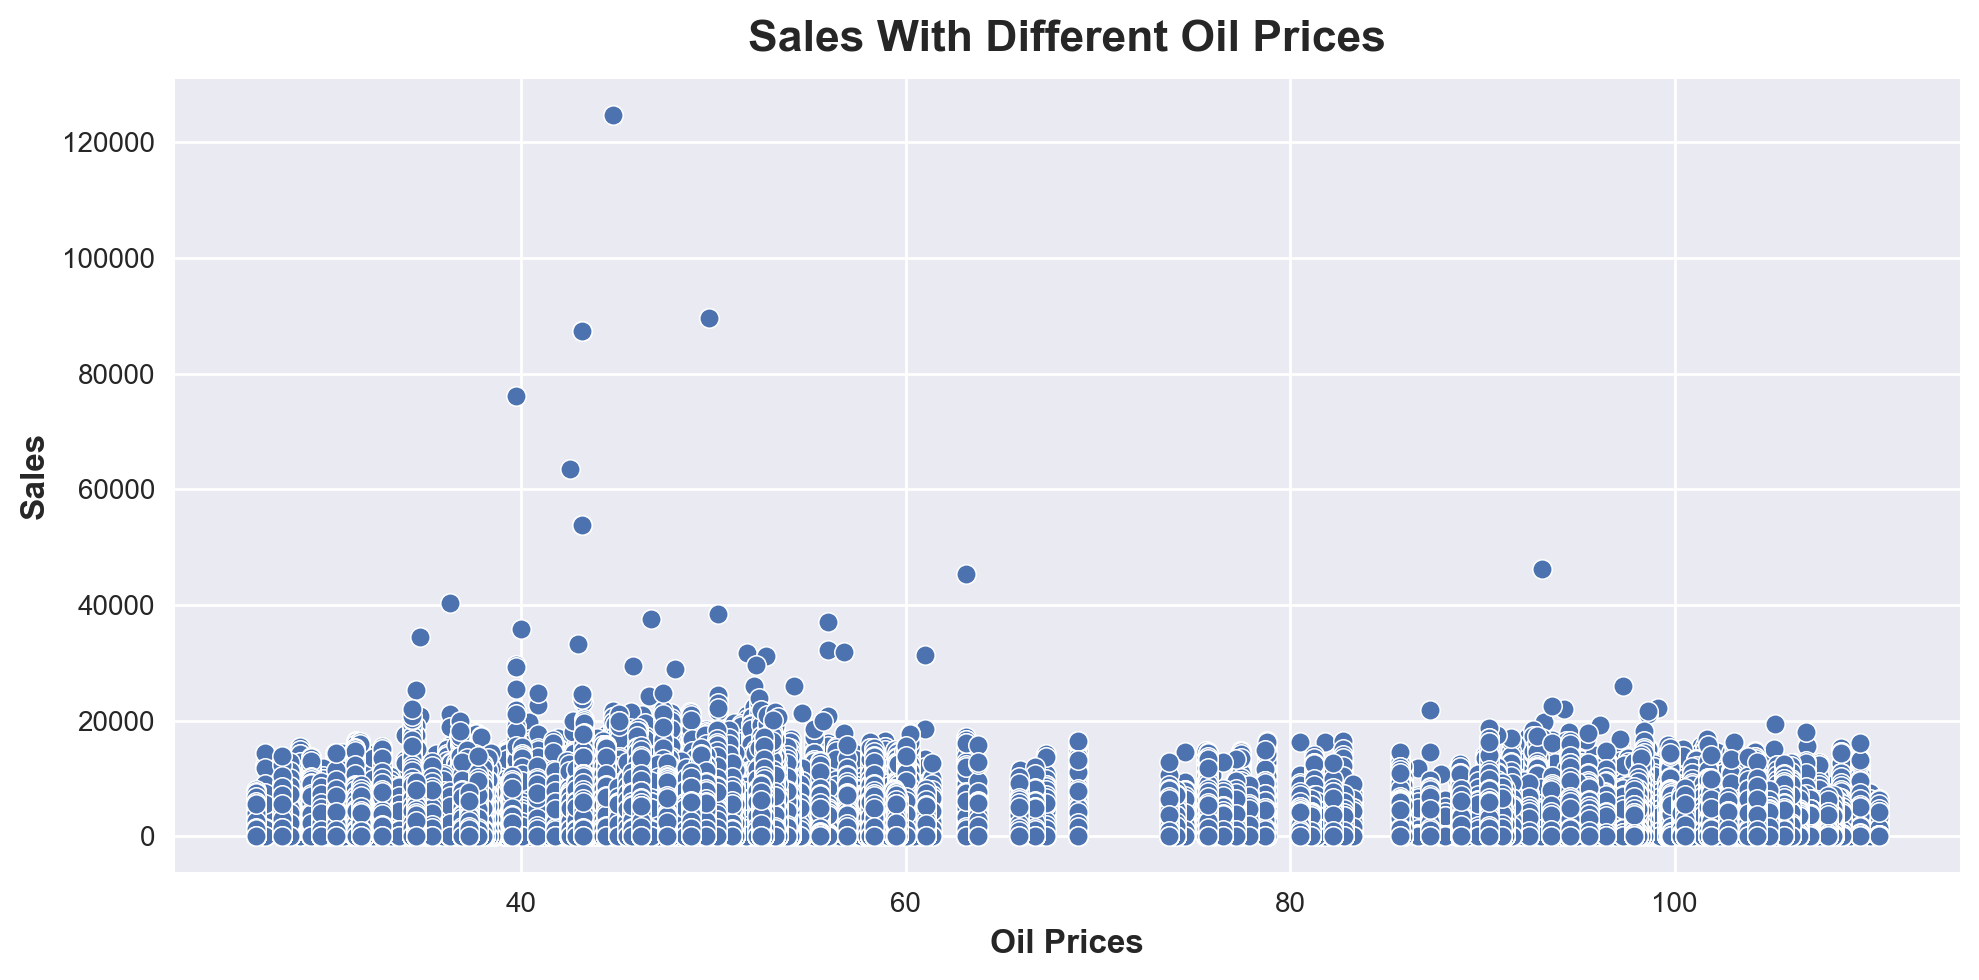

In [58]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='oil_price', y='sales', data=df)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

As seen from the above plot, the sales are not really affected by oil prices, the correlation coefficient of -0.07567496710860729 shows how weak of a relationship or nonexistent relationship between sales and oil prices.

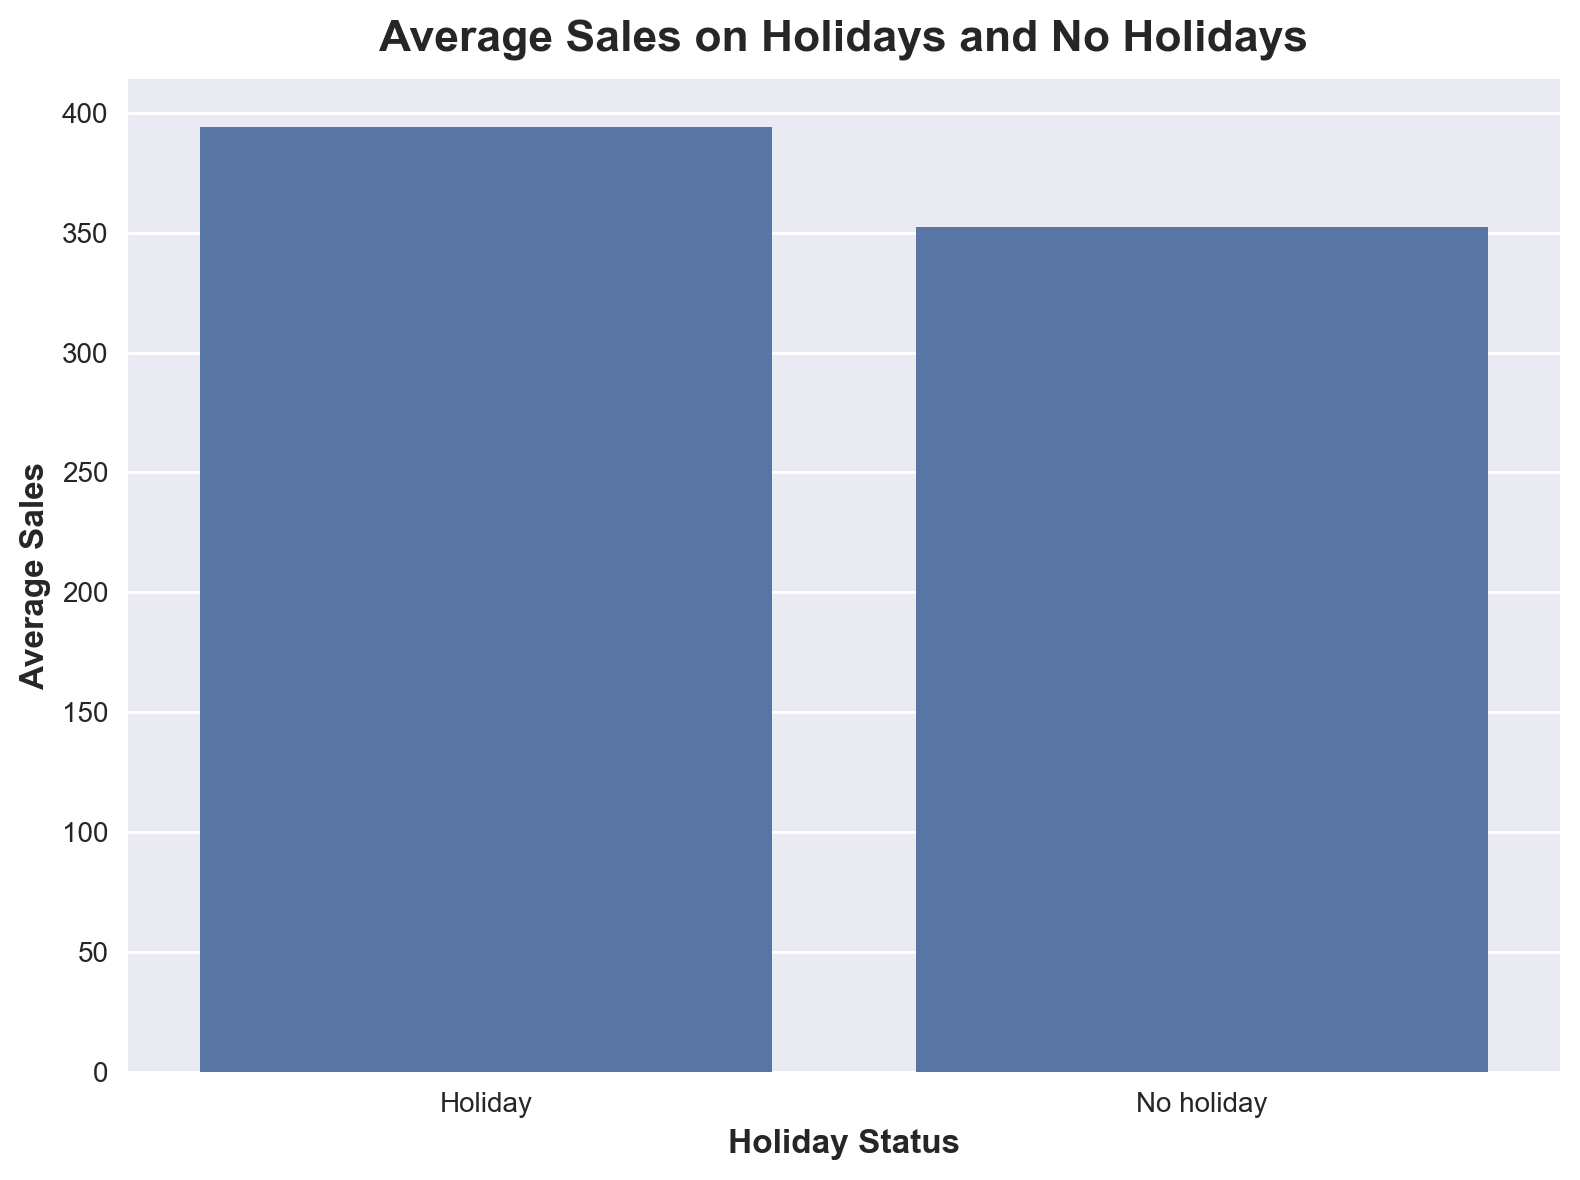

In [59]:
# Group the data by 'holiday_status' and calculate the average sales for each category
average_sales_by_holiday_status = df.groupby('holiday_status')['sales'].mean().reset_index()

# Plot the average sales for holidays and no holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_status', y='sales', data=average_sales_by_holiday_status)
plt.xlabel('Holiday Status')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays and No Holidays')
plt.show()

From the plot above, we can conclude that sales are affected by holidays, as the average sales on holidays are relatively higher than the average sales for no holidays.

7. What analysis can we get from the date and its extractable features?

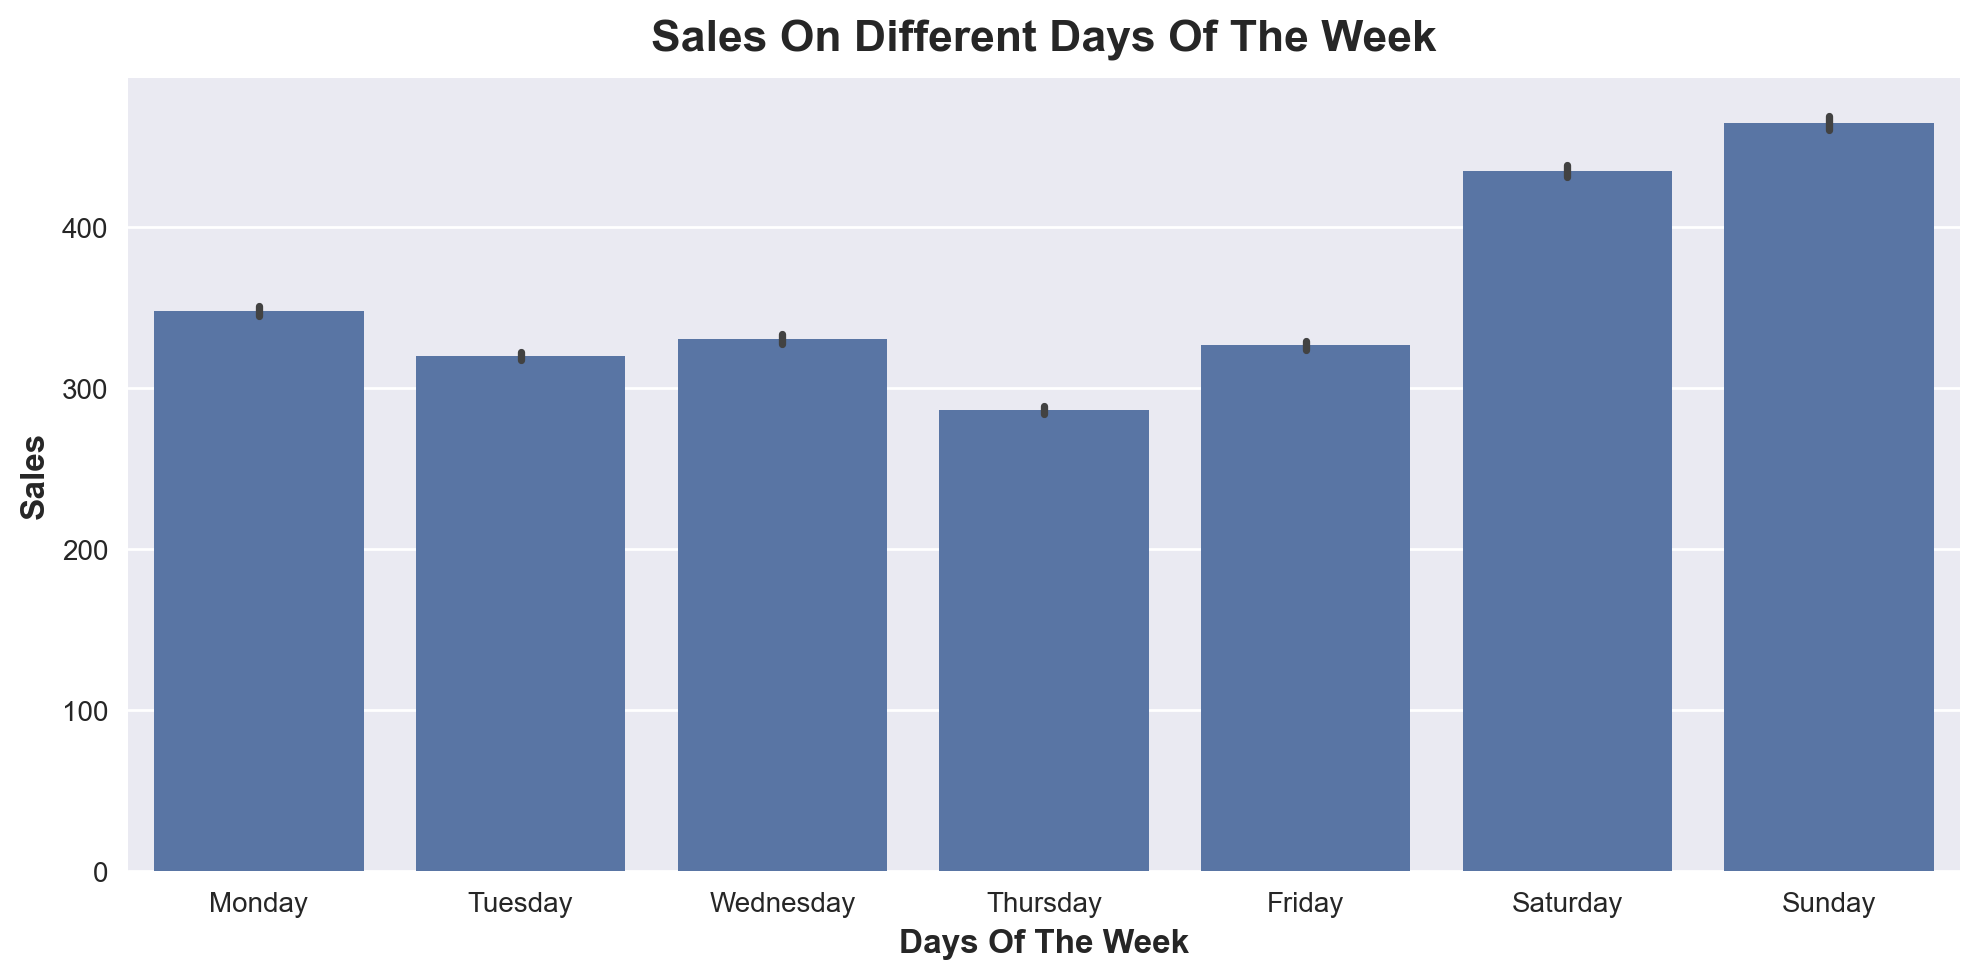

In [60]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=df, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

There are more sales during the weekends with peak sales on Sundays, followed by Saturdays. This could be because generally many people do not go to work (or only work few hours) during the weekends, and thus would have more time to shop during weeekends than weekdays. The least sales were on Thursdays, a quite busy day at at the middle of the week.

8. Which product family and stores did the promotions affect.

      store_nbr                      family  before_promotion_mean  \
0             1                  AUTOMOTIVE               2.288503   
2             1                      BEAUTY               1.876356   
3             1                   BEVERAGES             989.629067   
4             1                       BOOKS               0.000000   
5             1                BREAD/BAKERY             273.842442   
...         ...                         ...                    ...   
1776          9     PLAYERS AND ELECTRONICS               1.518438   
1777          9                     POULTRY             458.749027   
1778          9              PREPARED FOODS              69.804087   
1779          9                     PRODUCE             183.419544   
1780          9  SCHOOL AND OFFICE SUPPLIES               0.516269   

      during_promotion_mean     t_stat        p_value  
0                  3.605746 -10.171358   2.874662e-23  
2                  2.616121  -8.241209   4.8564

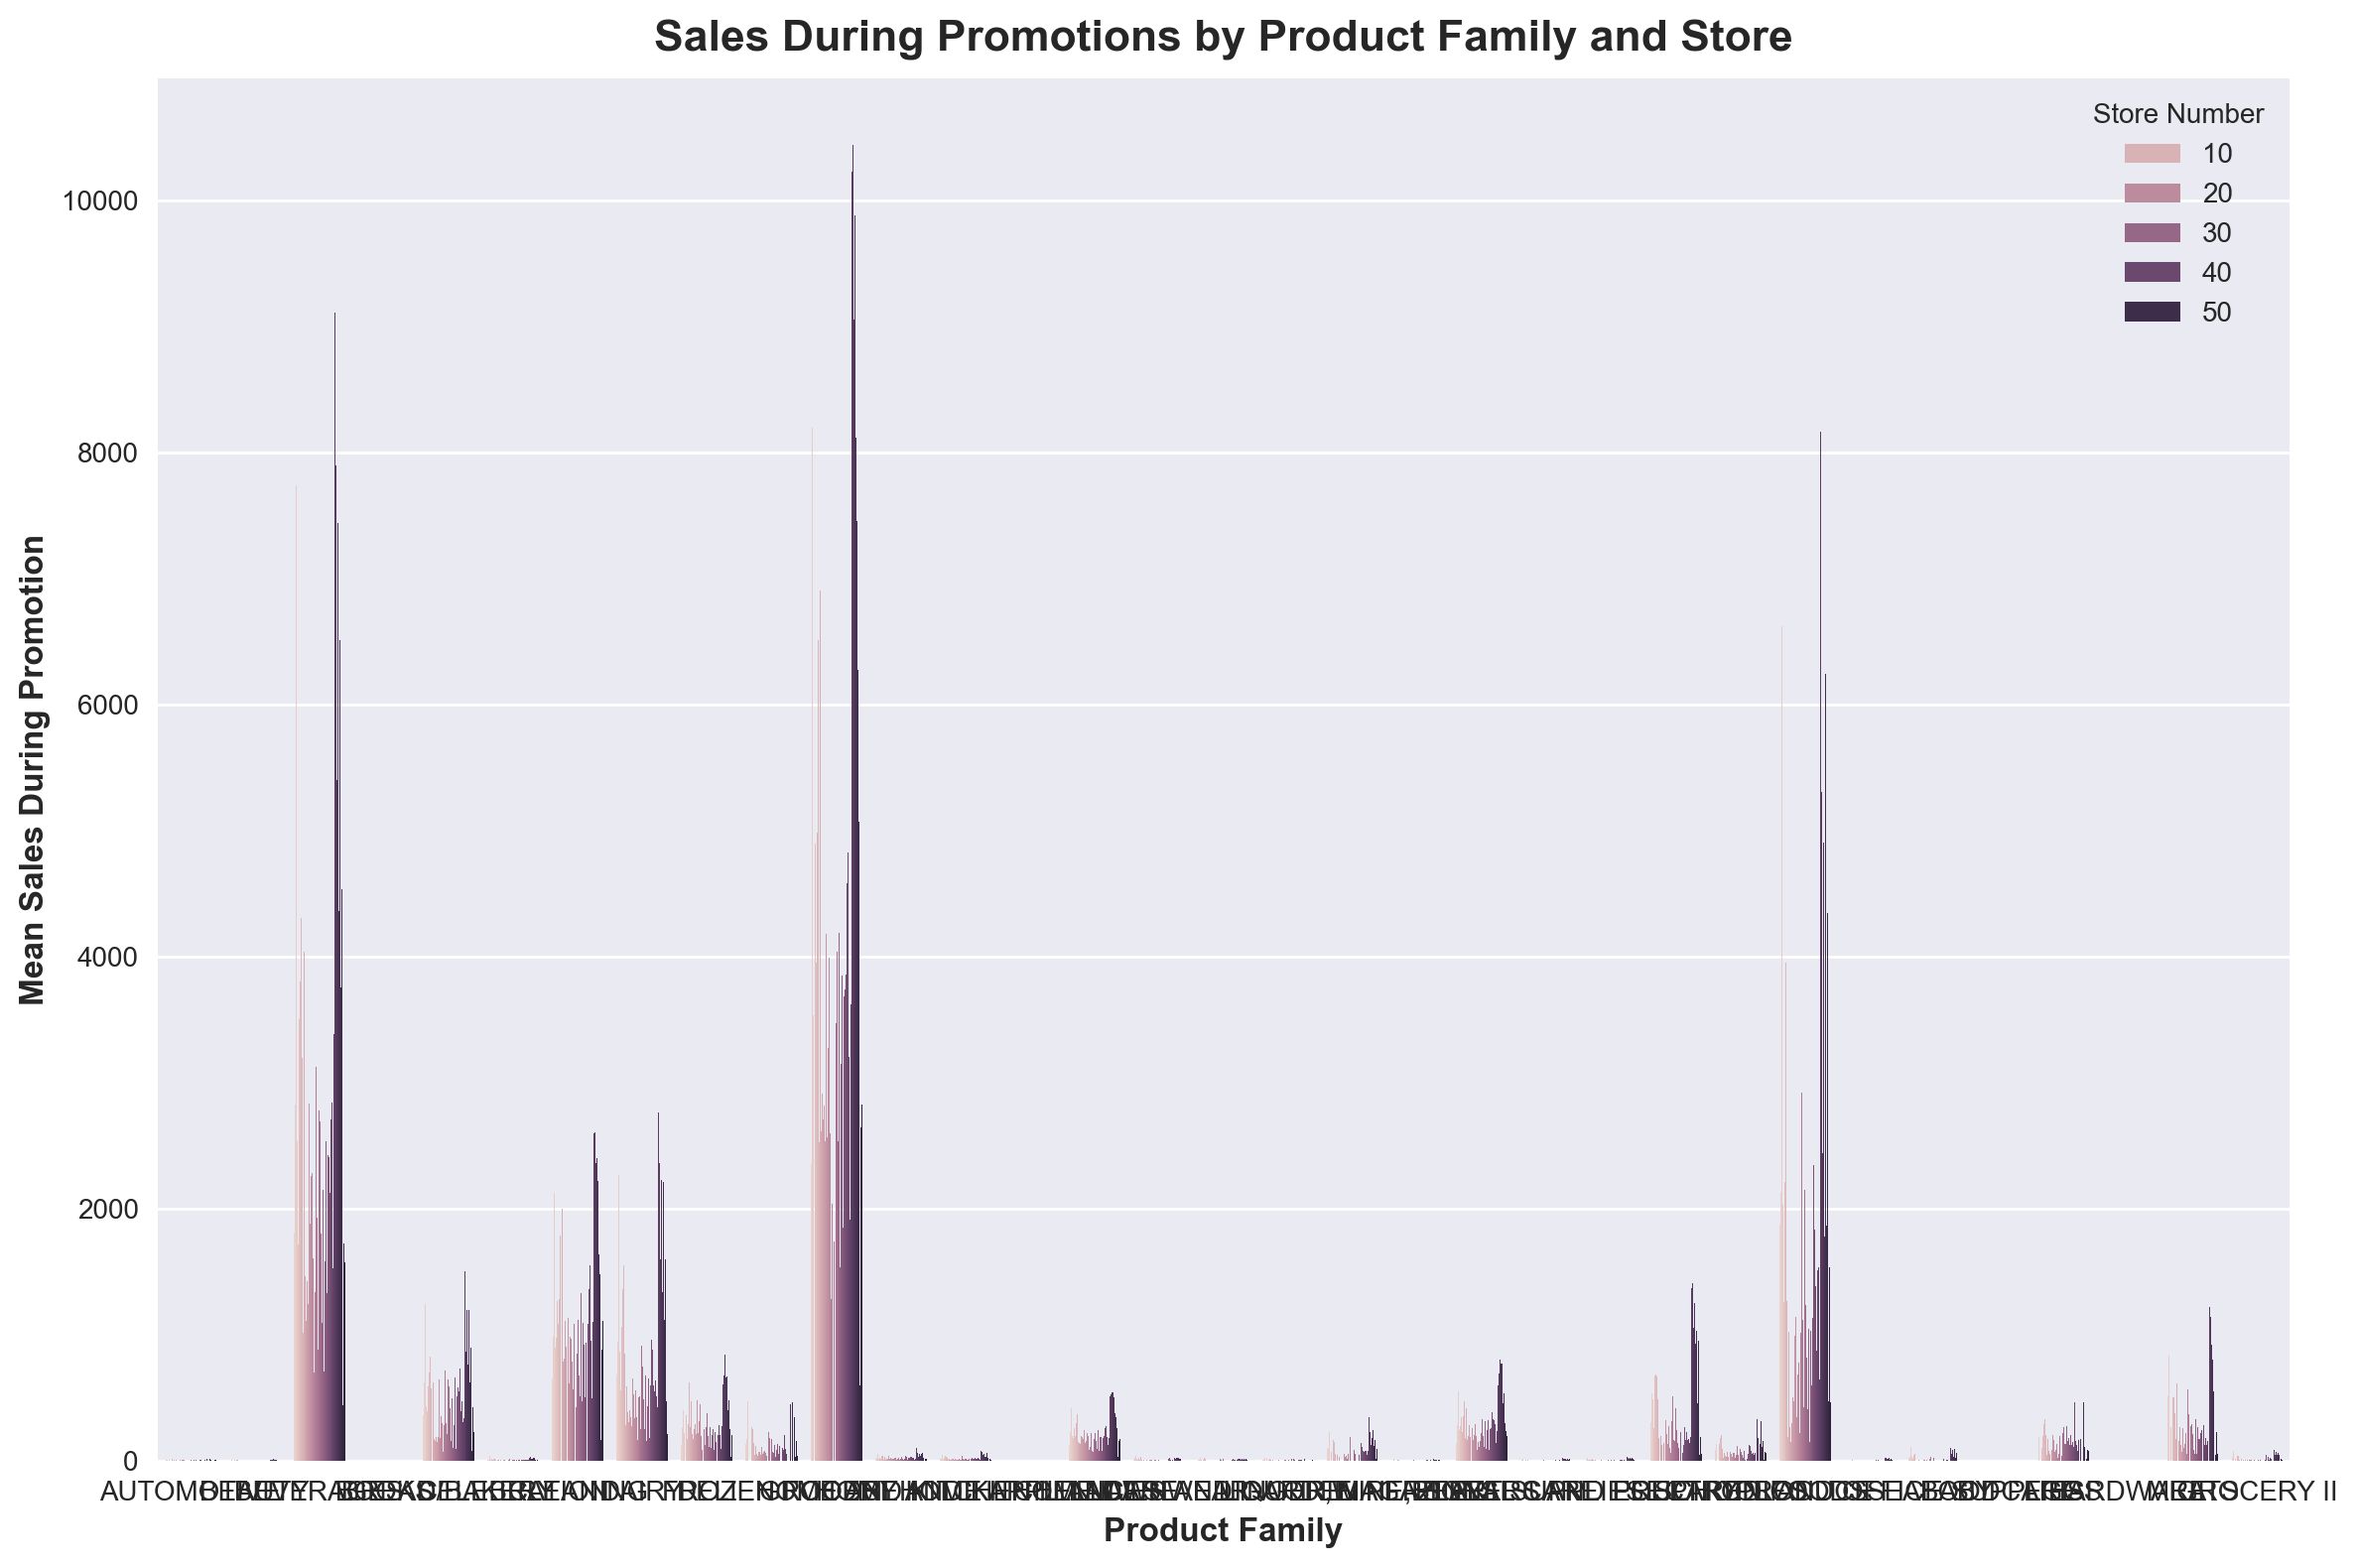

In [61]:

promotion_periods = df[df['onpromotion'] == True].index.unique()

# Create a DataFrame to store the results
results = []

# Iterate through each store and product family
for store in df['store_nbr'].unique():
    for family in df['family'].unique():
        # Filter data for the specific store and family
        store_family_data = df[(df['store_nbr'] == store) & (df['family'] == family)]
        
        # Calculate mean sales before, during, and after promotions
        before_promotion_sales = store_family_data[~store_family_data.index.isin(promotion_periods)]['sales']
        during_promotion_sales = store_family_data[store_family_data.index.isin(promotion_periods)]['sales']
        
        # Perform a t-test to see if the sales during promotion are significantly different from before promotion
        if len(before_promotion_sales) > 0 and len(during_promotion_sales) > 0:
            t_stat, p_value = ttest_ind(before_promotion_sales, during_promotion_sales, equal_var=False)
            results.append({
                'store_nbr': store,
                'family': family,
                'before_promotion_mean': before_promotion_sales.mean(),
                'during_promotion_mean': during_promotion_sales.mean(),
                't_stat': t_stat,
                'p_value': p_value
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter for significant results (e.g., p_value < 0.05)
significant_results = results_df[results_df['p_value'] < 0.05]

# Display significant results
print(significant_results)

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='family', y='during_promotion_mean', hue='store_nbr', data=significant_results)
plt.title('Sales During Promotions by Product Family and Store')
plt.xlabel('Product Family')
plt.ylabel('Mean Sales During Promotion')
plt.legend(title='Store Number')
plt.show()


9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is less sensitive to outliers but generally larger than RMSE and MSE.

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors, making it sensitive to outliers.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors and is less sensitive to outliers in the target variable.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?

Mean sales on payment days:  362.49489028142847
Mean sales on other days:  357.50074132058074
T-statistic for payment days vs other days:  1.957816869184039
P-value for payment days vs other days:  0.05025270384299515
Conclusion: Sales on payment days are not significantly different from sales on other days.
Mean sales on day before payment:  346.21901843751453
T-statistic for day before payment vs other days:  -4.583323543518636
P-value for day before payment vs other days:  4.57876484583293e-06
Conclusion: Sales on the day before payment are significantly different from sales on other days.
Mean sales on day after payment:  387.3632739661409
T-statistic for day after payment vs other days:  10.652695104016905
P-value for day after payment vs other days:  1.718691094105241e-26
Conclusion: Sales on the day after payment are significantly different from sales on other days.


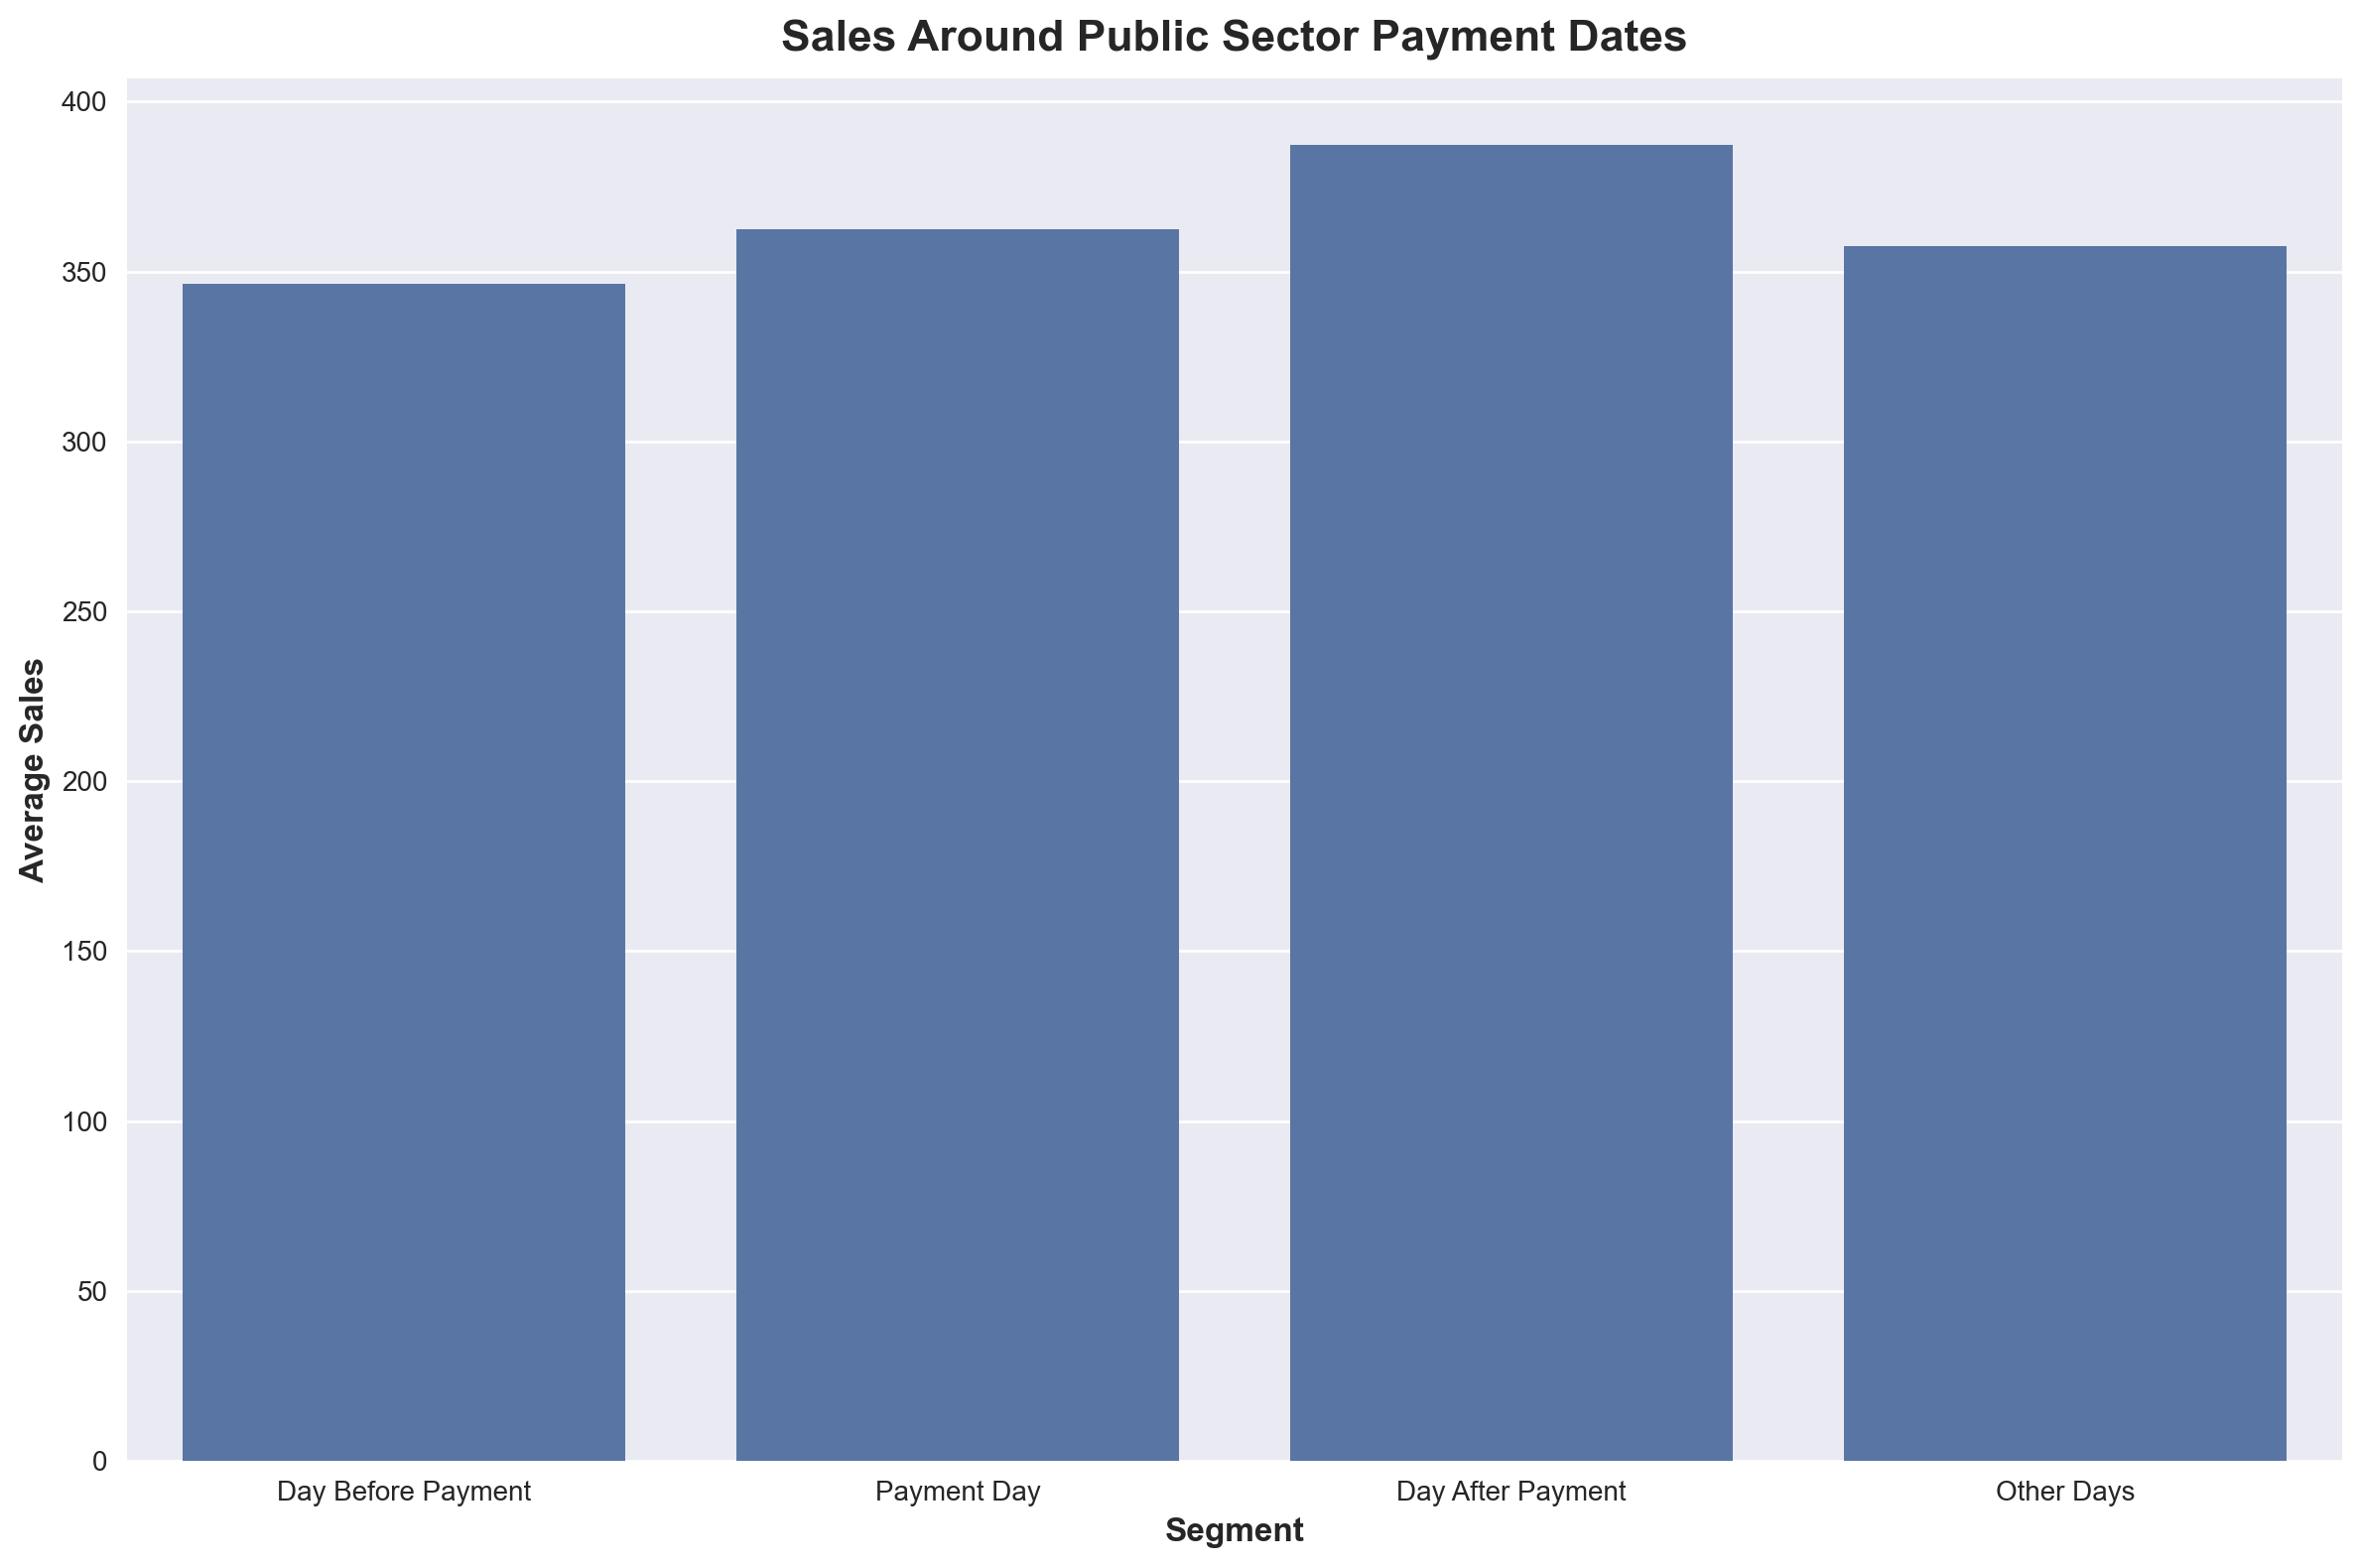

In [62]:


# Identify the 15th and last day of each month
payment_dates = df[(df.index.day == 15) | (df.index.is_month_end)].index

# Extract sales data for the day before, the day of, and the day after payment dates
day_before_payment = df[df.index.isin(payment_dates - pd.DateOffset(days=1))]['sales']
payment_day = df[df.index.isin(payment_dates)]['sales']
day_after_payment = df[df.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Extract sales data for other days
other_days = df[~df.index.isin(payment_dates) & 
                ~df.index.isin(payment_dates - pd.DateOffset(days=1)) & 
                ~df.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Perform t-tests to see if sales on payment days are significantly different from other days
t_stat_payment, p_value_payment = ttest_ind(payment_day, other_days, equal_var=False)
t_stat_before, p_value_before = ttest_ind(day_before_payment, other_days, equal_var=False)
t_stat_after, p_value_after = ttest_ind(day_after_payment, other_days, equal_var=False)

# Display the results
print("Mean sales on payment days: ", payment_day.mean())
print("Mean sales on other days: ", other_days.mean())
print("T-statistic for payment days vs other days: ", t_stat_payment)
print("P-value for payment days vs other days: ", p_value_payment)
if p_value_payment < 0.05:
    print("Conclusion: Sales on payment days are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on payment days are not significantly different from sales on other days.")

print("Mean sales on day before payment: ", day_before_payment.mean())
print("T-statistic for day before payment vs other days: ", t_stat_before)
print("P-value for day before payment vs other days: ", p_value_before)
if p_value_before < 0.05:
    print("Conclusion: Sales on the day before payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day before payment are not significantly different from sales on other days.")

print("Mean sales on day after payment: ", day_after_payment.mean())
print("T-statistic for day after payment vs other days: ", t_stat_after)
print("P-value for day after payment vs other days: ", p_value_after)
if p_value_after < 0.05:
    print("Conclusion: Sales on the day after payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day after payment are not significantly different from sales on other days.")

# Visualization
segments = ['Day Before Payment', 'Payment Day', 'Day After Payment', 'Other Days']
means = [day_before_payment.mean(), payment_day.mean(), day_after_payment.mean(), other_days.mean()]

plt.figure(figsize=(12, 8))
sns.barplot(x=segments, y=means)
plt.title('Sales Around Public Sector Payment Dates')
plt.xlabel('Segment')
plt.ylabel('Average Sales')
plt.show()


## **Model Building**

In [63]:
df.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'oil_price', 'city', 'state', 'store_type', 'cluster', 'holiday_status',
       'year', 'month', 'dayofmonth', 'dayofweek', 'dayname',
       'promotion_status'],
      dtype='object')

In [64]:
train_df = df.copy()

In [65]:
# Drop some columns and display the dataset
columns_to_drop = ['id','promotion_status', 'transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'oil_price', 'city',
                   'state', 'store_type', 'cluster', 'holiday_status', 'month', 'dayofmonth', 'dayofweek', 'dayname']
train_df = train_df.drop(columns_to_drop, axis=1)

In [66]:
train_df.head()

,store_nbr,family,sales,onpromotion,year
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013
2013-01-01,1,BABY CARE,0.0,0,2013
2013-01-01,1,BEAUTY,0.0,0,2013
2013-01-01,1,BEVERAGES,0.0,0,2013
2013-01-01,1,BOOKS,0.0,0,2013


We then go ahead to split our data into training and validation sets using the time-based split. This will be done based on the years.

In [67]:
# List the years in the dataset

train_df['year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [68]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = train_df.loc[(train_df['year'].isin(train_years) & train_df['year'].isin(train_years))]
val_set = train_df.loc[(train_df['year'].isin(val_year) & train_df['year'].isin(val_year))]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 5), (411642, 5))

In [69]:
# Check the datatypes of the columns of the training set

train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642706 entries, 2013-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
 4   year         int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 110.9+ MB


In [70]:
# Extract the original index column for later use
train_index = train_set.index
val_index = val_set.index

# Obtain the categorical columns to encode and numerical columns to scale (I dropped the 'Year' column here)
cat_columns_to_encode = ['family']
num_columns_to_scale = ['store_nbr', 'onpromotion', 'sales']

# Create seperate DataFrames for categorical columns and numerical columns of training set
train_set_cat_df = train_set[cat_columns_to_encode]
train_set_num_df = train_set[num_columns_to_scale]

# Create seperate DataFrames for categorical columns and numerical columns of validation set
val_set_cat_df = val_set[cat_columns_to_encode]
val_set_num_df = val_set[num_columns_to_scale]

## Feature Encoding

In [72]:
# Set sparse=False for dense output and drop='first' to avoid multicollinearity

encoder = OneHotEncoder(sparse_output=False, drop='first')

In [73]:
# Use OneHotEncoder to encode the categorical columns of the training set
encoder.fit(train_set_cat_df)
train_set_cat_encoded = encoder.transform(train_set_cat_df).tolist()
train_set_cat_encoded_df = pd.DataFrame(train_set_cat_encoded, columns=encoder.get_feature_names_out(), index=train_index)

# View the encoded columns of the training set
train_set_cat_encoded_df.head()